# Data Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math


df = pd.read_parquet("../../data/parllaw/speech_embeddings.parquet")
print(f"#Samples: {len(df)}")

#Samples: 9705


In [2]:
df.head(5)

,Unnamed: 0,speaker,text,date,agenda,speechnumber,procedure_ID,partyfacts_ID,period,chair,...,party,migration_prob,jinaai/jina-embeddings-v3,jinaai/jina-embeddings-v4,Snowflake/snowflake-arctic-embed-l-v2.0,BAAI/bge-m3,sentence-transformers/all-MiniLM-L6-v2,sentence-transformers/all-mpnet-base-v2,Qwen/Qwen3-Embedding-0.6B,google/embeddinggemma-300m
492,492,Karen Melchior,"Mr President, thank you very much to the Commi...",2024-04-24,22. Advance passenger information: enhancing a...,8,bill_26075_ID bill_26076_ID bill_26075_ID bi...,6401.0,9,False,...,ELDR/ALDE/Renew,0.393282,"[0.03173828, -0.05883789, 0.06347656, 0.061523...","[-0.017475849, -0.0234765, 0.01301684, 0.00316...","[0.029303519, 0.02908727, 0.04424794, 0.051043...","[0.00046046128, 0.041610897, -0.023090536, -0....","[0.020603927, -0.017596412, 0.0006259507, -0.0...","[0.009955298, 0.01231596, -0.031741396, 0.0164...","[-0.031322084, 0.030157333, -0.005754259, -0.0...","[-0.06368264, -0.01790871, 0.008169121, 0.0173..."
844,844,Tineke Strik,"Mr President, Commissioner. People who flee wa...",2024-04-23,17. EU-Egypt strategic and comprehensive partn...,9,,6403.0,9,False,...,Greens/EFA,0.423501,"[0.046142578, -0.076660156, 0.03930664, -0.024...","[-0.012335925, -0.012685713, 0.007637553, 0.03...","[0.0022561324, 0.03212409, 0.01491972, 0.02270...","[-0.014090479, 0.02344181, -0.032296076, 0.005...","[-0.03277658, 0.075279415, 0.00988437, -0.0314...","[0.050362997, 0.031640317, 0.0033627285, 0.010...","[0.0490291, -0.0001613221, -0.007507243, 0.003...","[-0.06358229, 0.05332363, -0.006831329, 0.0041..."
1050,1050,Anabela Rodrigues,"Senhora Presidente, em 2024, o tráfico de sere...",2024-04-22,20. Amending Directive 2011/36/EU on preventin...,10,bill_241_ID bill_241_ID,6402.0,9,False,...,NGL/The Left,0.375925,"[-0.02368164, -0.11767578, 0.041503906, -0.015...","[-0.006263365, -0.0037057083, 0.003096705, 0.0...","[0.017229473, 0.052975528, 0.015071628, -0.019...","[-0.037878938, 0.04945201, -0.028479485, 0.008...","[-3.740648e-05, 0.042549398, -0.01705076, -0.0...","[-0.016886365, 0.02107416, 0.022850083, -0.003...","[0.005645505, 0.03181904, -0.0033138462, 0.033...","[-0.049918693, -0.001202861, -0.008896867, -0...."
1054,1054,Beata Kempa,Pani Przewodnicząca! Pani Komisarz! Potrzebuje...,2024-04-22,20. Amending Directive 2011/36/EU on preventin...,14,bill_241_ID bill_241_ID,6400.0,9,False,...,ECR,0.256493,"[0.028686523, -0.09667969, 0.08251953, 0.00303...","[0.0019489997, -0.00825006, 0.032056473, 0.004...","[-0.011141846, -0.009032944, -0.04128787, 0.01...","[-0.023567535, 0.005077537, -0.07184075, 0.013...","[-0.0042979075, 0.079598755, -0.070720166, -0....","[0.0069901105, -0.003832352, 0.014021035, 0.03...","[-0.04446165, 0.02761738, -0.00755511, 0.07728...","[-0.035047594, 0.03835739, -0.051198084, 0.050..."
1056,1056,Dorien Rookmaker,"Voorzitter, dank u wel, meneer Engerer, want u...",2024-04-22,20. Amending Directive 2011/36/EU on preventin...,16,bill_241_ID bill_241_ID,6400.0,9,False,...,ECR,0.475315,"[0.02709961, -0.13085938, 0.049560547, -0.0139...","[-0.015246119, -0.009003674, 0.019220384, 0.01...","[-0.027185386, -0.015011083, 0.005534012, -0.0...","[-0.0021237587, -0.027706854, -0.04229295, 0.0...","[-0.10969446, 0.08347164, 0.015826896, -0.0843...","[0.05082612, -0.035786744, 0.014009577, 0.0413...","[-0.050546486, -0.012648543, -0.008574607, 0.0...","[-0.06766452, 0.015919995, -0.019874139, -0.01..."


In [3]:
MODELS = ["jinaai/jina-embeddings-v3",
          "jinaai/jina-embeddings-v4",
           "Snowflake/snowflake-arctic-embed-l-v2.0", "BAAI/bge-m3", 
           'sentence-transformers/all-MiniLM-L6-v2', 
           'sentence-transformers/all-mpnet-base-v2', 
           'Qwen/Qwen3-Embedding-0.6B', 'google/embeddinggemma-300m']

# Helper Functions

# Embedding Evaluation

## PLS - Partial Least Squares Regression

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import PLSRegression


def pls_coefficient_of_determination(model: str, target_var: str, categorical: bool = True) -> float:
    X = np.stack(df[model])
    if categorical:
        # If we have categorical target, create one-hot encodding to adapt PLS for classification (PLS-DA)
        lb = LabelEncoder()
        y = lb.fit_transform(df[target_var])

        y = np.eye(len(lb.classes_))[y]
    else:
        y = np.stack(df[target_var])

    pls = PLSRegression(n_components=2)
    pls.fit(X, y)
    return pls.score(X, y)


## Measure Group Cohesiveness

In [5]:
def get_intra_inter_similarities(model: str, group_col: str, weighted: bool = False) -> list[dict]:
    embeddings = np.stack(df[model])
    normalized_embeddings = embeddings / np.linalg.vector_norm(embeddings, axis=1, ord=2, keepdims=True)
    similarities = normalized_embeddings @ normalized_embeddings.T

    if weighted:
        mig_prob_vec = np.stack(df['migration_prob'])
        mig_prob_vec = mig_prob_vec / np.linalg.vector_norm(mig_prob_vec, ord=2)
        weights = mig_prob_vec[:, np.newaxis] @ mig_prob_vec[np.newaxis, :]
        similarities *= weights

    classes = df[group_col].unique()
    results = []

    for class_ in classes:
        intra = similarities[df[group_col] == class_][:, df[group_col] == class_].mean()
        inter = similarities[df[group_col] == class_][:, df[group_col] != class_].mean()
        results.append({'class': class_, 'intra': intra, 'inter': inter, 'size': sum(df[group_col] == class_)})
    return results

In [6]:
def get_cohesivness(model: str, group_col: str, weighted: bool = False) -> float:
    similarities = get_intra_inter_similarities(model=model, group_col=group_col, weighted=weighted)
    size = sum(sim['size'] for sim in similarities)
    cohesivness = sum((sim['intra'] / sim['inter'] - 1) * sim['size'] for sim in similarities) / size
    return cohesivness.item()

## Clustering Quality

In [7]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.cluster import KMeans

def evaluate_kmeans(true_labels, cluster_labels) -> dict[str, float]:
    h = homogeneity_score(true_labels, cluster_labels)
    c = completeness_score(true_labels, cluster_labels)
    v = v_measure_score(true_labels, cluster_labels)
 
    return {"homogeneity": h, "completeness": c, "v_measure": v}


def get_cluster_quality(model: str, target_var: str, weighted: bool = False) -> dict[str, float]:
    kmeans = KMeans(n_clusters=len(df[target_var].unique()), random_state=42)
    predicted_clusters = kmeans.fit_predict(np.stack(df[model]), sample_weight=df['migration_prob'] if weighted else None)
    return evaluate_kmeans(true_labels=df[target_var], cluster_labels=predicted_clusters)


## Leaderboard

In [8]:
from tqdm import tqdm
results = []
for model in tqdm(MODELS):
    for target in ['party', 'block']:
        r_2 = pls_coefficient_of_determination(model, target)
        cohesivness = get_cohesivness(model, target)
        cluster_quality = get_cluster_quality(model, target)
        results.append({"model": model, "target": target, "r_2": r_2, "cohesivness": cohesivness, "v_measure": cluster_quality['v_measure']})
    r_2_mig = pls_coefficient_of_determination(model, "migration_prob", categorical=False)
    cohesivness_weighted = get_cohesivness(model, "party", weighted=True)
    cluster_quality_weighted = get_cluster_quality(model, "party", weighted=True)
    results.append({"model": model, "target": "weighted", "r_2": r_2_mig, "cohesivness": cohesivness_weighted, "v_measure": cluster_quality_weighted['v_measure']})

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:56<00:00,  7.05s/it]


In [9]:
leaderboard = pd.DataFrame(results)
leaderboard

,model,target,r_2,cohesivness,v_measure
0,jinaai/jina-embeddings-v3,party,0.068993,0.022832,0.074474
1,jinaai/jina-embeddings-v3,block,0.092233,0.018806,0.058355
2,jinaai/jina-embeddings-v3,weighted,0.460549,0.024657,0.081301
3,jinaai/jina-embeddings-v4,party,0.078889,0.014439,0.048595
4,jinaai/jina-embeddings-v4,block,0.103882,0.011724,0.038392
5,jinaai/jina-embeddings-v4,weighted,0.507233,0.016430,0.025886
6,Snowflake/snowflake-arctic-embed-l-v2.0,party,0.089134,0.031280,0.047084
7,Snowflake/snowflake-arctic-embed-l-v2.0,block,0.117365,0.024412,0.032189
8,Snowflake/snowflake-arctic-embed-l-v2.0,weighted,0.494600,0.033575,0.041394
9,BAAI/bge-m3,party,0.076115,0.015321,0.049298


In [10]:
# normalize metrics across targets
metrics = ["r_2", "cohesivness", "v_measure"]
targets = ["party", "block", "weighted"]
for target in targets:
    for metric in metrics:
       leaderboard.loc[leaderboard["target"] == target, metric] /= leaderboard.loc[leaderboard["target"] == target, metric].sum()
    

In [131]:
leaderboard['mean_score'] = leaderboard[metrics].apply(np.mean, axis=1)

In [ ]:
leaderboard 

,model,target,r_2,cohesivness,v_measure,mean_score
0,jinaai/jina-embeddings-v3,party,0.117538,0.067646,0.115486,0.100223
1,jinaai/jina-embeddings-v3,block,0.125775,0.085646,0.143421,0.118281
2,jinaai/jina-embeddings-v3,weighted,0.148798,0.070319,0.121434,0.113517
3,jinaai/jina-embeddings-v4,party,0.134398,0.042778,0.075357,0.084178
4,jinaai/jina-embeddings-v4,block,0.141661,0.053394,0.094357,0.096471
5,jinaai/jina-embeddings-v4,weighted,0.163881,0.046855,0.038664,0.083133
6,Snowflake/snowflake-arctic-embed-l-v2.0,party,0.151852,0.092675,0.073012,0.105846
7,Snowflake/snowflake-arctic-embed-l-v2.0,block,0.160048,0.111178,0.079112,0.116779
8,Snowflake/snowflake-arctic-embed-l-v2.0,weighted,0.159800,0.095749,0.061827,0.105792
9,BAAI/bge-m3,party,0.129671,0.045392,0.076446,0.083836


Low r_2 means our dimensionality reduction won't be interpretable. If we want both descent clustering and interpratable lower dimensional axis we should go for google/embeddinggemma-300m otherwise we should probably use sentence-transformers/all-mpnet-base-v2	instead

In [133]:
leaderboard.groupby('model')['mean_score'].mean()

model
BAAI/bge-m3                                0.093485
Qwen/Qwen3-Embedding-0.6B                  0.111553
Snowflake/snowflake-arctic-embed-l-v2.0    0.109473
google/embeddinggemma-300m                 0.151075
jinaai/jina-embeddings-v3                  0.110674
jinaai/jina-embeddings-v4                  0.087927
sentence-transformers/all-MiniLM-L6-v2     0.185157
sentence-transformers/all-mpnet-base-v2    0.150657
Name: mean_score, dtype: float64

In [123]:
metrics = ["r_2", "cohesivness", "v_measure"]
targets = ["party", "block", "weighted"]
summary = []
for target in targets:
    for metric in metrics:
        best = leaderboard.loc[leaderboard[leaderboard['target'] == target][metric].idxmax()]
        summary.append({"best_model": best['model'], "target": best['target'], "metric": metric, "score": best[metric]})
    

In [124]:
pd.DataFrame(summary).set_index(["target", "metric"])

best_model     score
target   metric                                                        
party    r_2          Snowflake/snowflake-arctic-embed-l-v2.0  0.089134
         cohesivness   sentence-transformers/all-MiniLM-L6-v2  0.107976
         v_measure     sentence-transformers/all-MiniLM-L6-v2  0.138059
block    r_2          Snowflake/snowflake-arctic-embed-l-v2.0  0.117365
         cohesivness   sentence-transformers/all-MiniLM-L6-v2  0.059961
         v_measure    sentence-transformers/all-mpnet-base-v2  0.079933
weighted r_2                        jinaai/jina-embeddings-v4  0.507233
         cohesivness   sentence-transformers/all-MiniLM-L6-v2  0.108097
         v_measure    sentence-transformers/all-mpnet-base-v2  0.138932

# Embedding Evaluation

In [304]:
import pandas as pd

In [315]:
df = pd.read_parquet("data/speech_embeddings (1).parquet")
# text_data = pd.read_csv("data/migration_speeches_lda (2).csv", sep="\t")
# df = df.merge(text_data, how='left', on=['date', 'speechnumber', 'agenda'])
df.columns

Index(['speaker', 'text', 'eu_party', 'date', 'agenda', 'speechnumber',
       'period', 'national_party', 'country', 'jinaai/jina-embeddings-v4',
       'Snowflake/snowflake-arctic-embed-l-v2.0', 'BAAI/bge-m3',
       'sentence-transformers/all-MiniLM-L6-v2',
       'sentence-transformers/all-mpnet-base-v2', 'Qwen/Qwen3-Embedding-0.6B',
       'google/embeddinggemma-300m', 'jinaai/jina-embeddings-v3'],
      dtype='object')

In [306]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import numpy as np

## Clustering Quality

In [ ]:

models = ["jinaai/jina-embeddings-v3",
          "jinaai/jina-embeddings-v4",
           "Snowflake/snowflake-arctic-embed-l-v2.0", "BAAI/bge-m3", 
           'sentence-transformers/all-MiniLM-L6-v2', 
           'sentence-transformers/all-mpnet-base-v2', 
           'Qwen/Qwen3-Embedding-0.6B', 'google/embeddinggemma-300m']

def evaluate_kmeans(true_labels, cluster_labels):
    h = homogeneity_score(true_labels, cluster_labels)
    c = completeness_score(true_labels, cluster_labels)
    v = v_measure_score(true_labels, cluster_labels)
 
    return {"homogeneity": h, "completeness": c, "v_measure": v}

computed_metrics = []
for model in models:
    kmeans = KMeans(n_clusters=len(df['eu_party'].unique()), random_state=42)
    predicted_clusters = kmeans.fit_predict(np.stack(df[model]))
    print(f"Model - {model}")
    scores = evaluate_kmeans(true_labels=df["eu_party"], cluster_labels=predicted_clusters)
    computed_metrics.append(scores)
    


Model - jinaai/jina-embeddings-v3
Model - jinaai/jina-embeddings-v4
Model - Snowflake/snowflake-arctic-embed-l-v2.0
Model - BAAI/bge-m3
Model - sentence-transformers/all-MiniLM-L6-v2
Model - sentence-transformers/all-mpnet-base-v2
Model - Qwen/Qwen3-Embedding-0.6B
Model - google/embeddinggemma-300m


<Axes: title={'center': 'EU parties clustering quality by models'}>

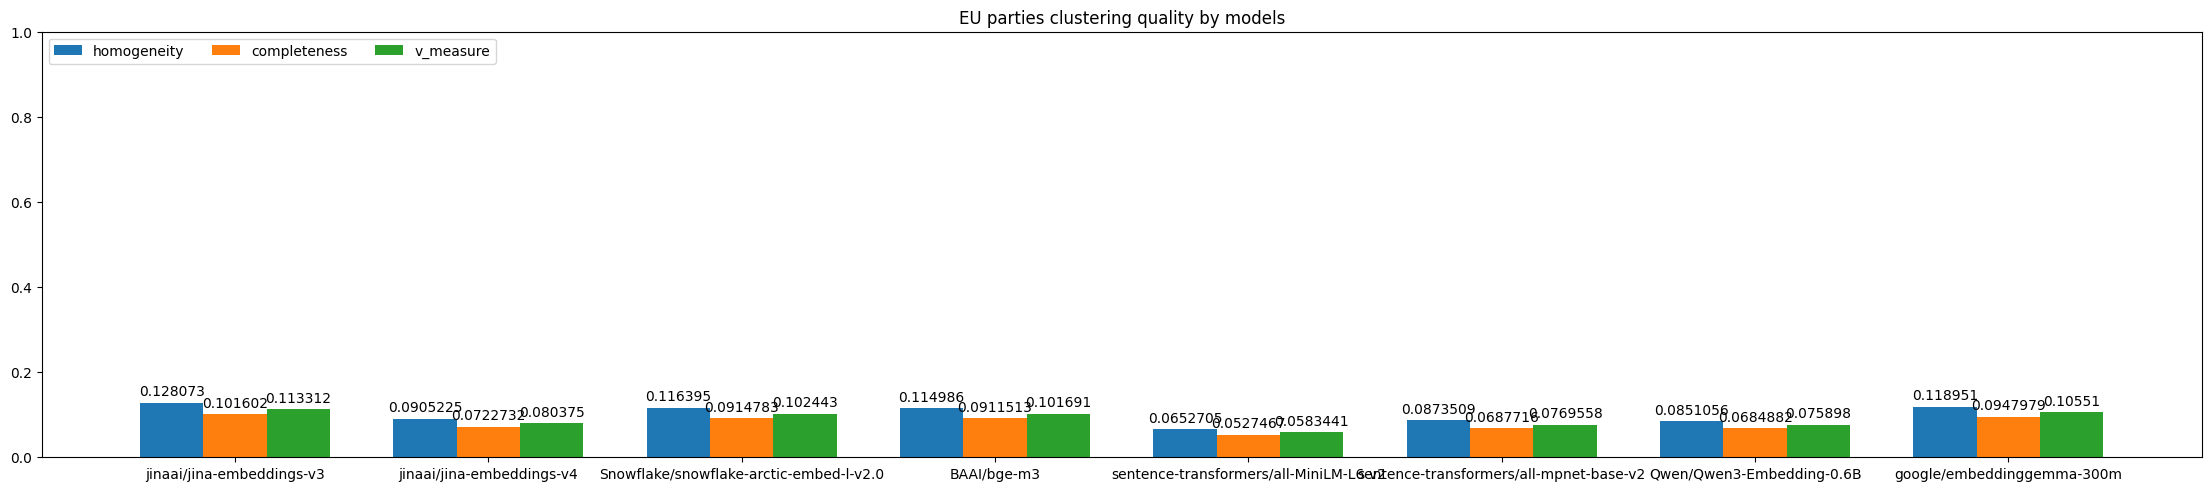

In [312]:
def plot_quality(computed_metrics, title='Clustering quality by models'):
    fig, ax = plt.subplots(layout='constrained')
    fig.set_figwidth(22)
    x = np.arange(len(models))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    metrics = {metric: [metrics[metric] for metrics in computed_metrics] for metric in  computed_metrics[0].keys()}

    for attribute, measurement in metrics.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_ylim([0, 1.])
    ax.set_title(title)
    ax.set_xticks(x + width, models)
    ax.legend(loc='upper left', ncols=3)
    return ax

plot_quality(computed_metrics, "EU parties clustering quality by models")

# Focuse on the cleaning and then choose the model? 

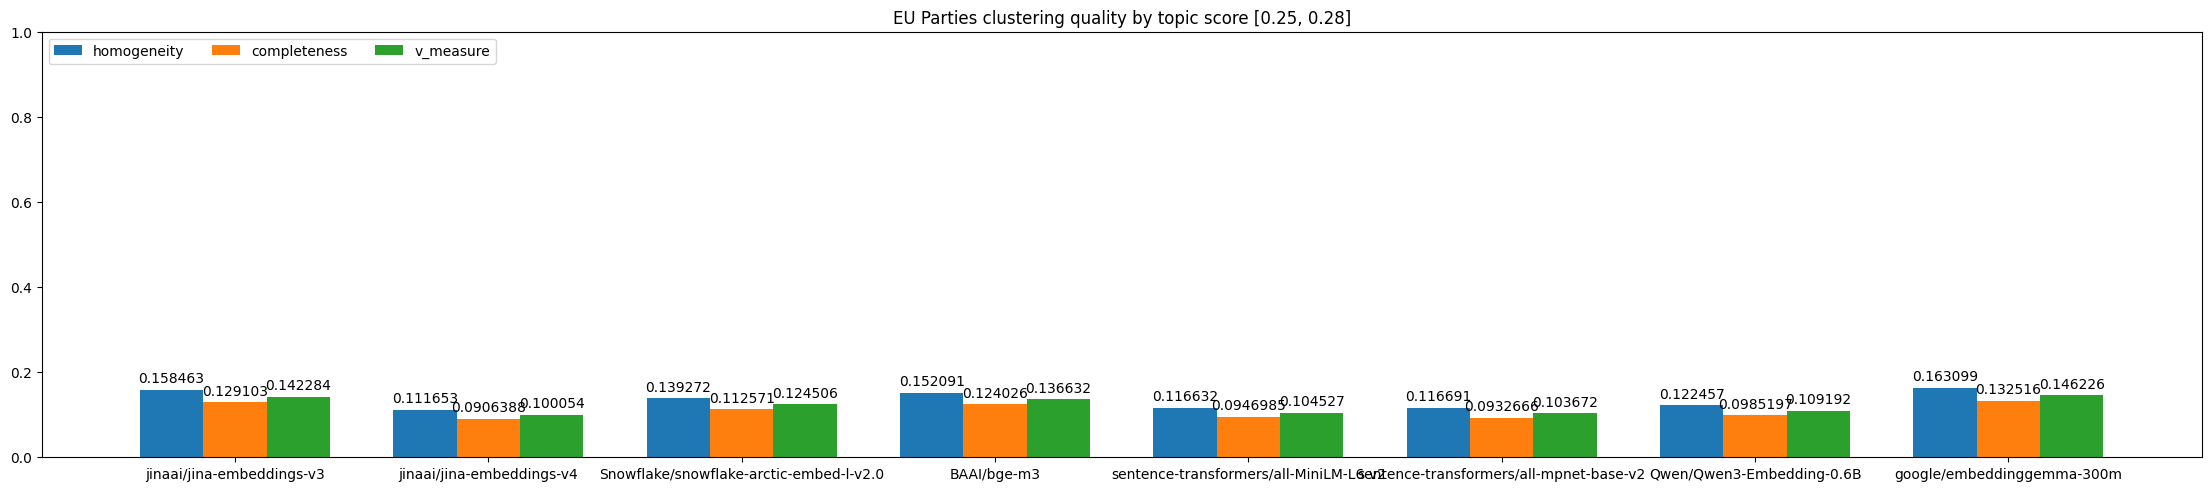

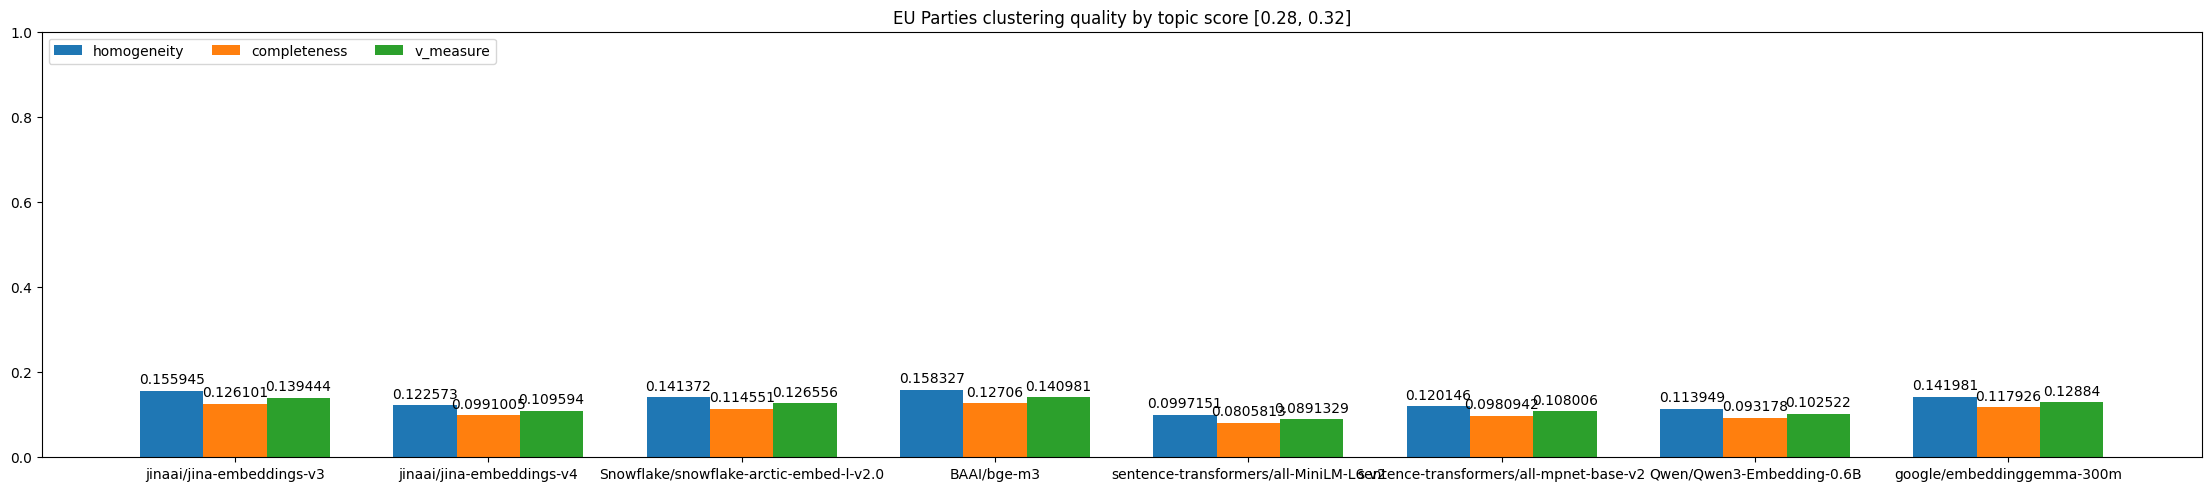

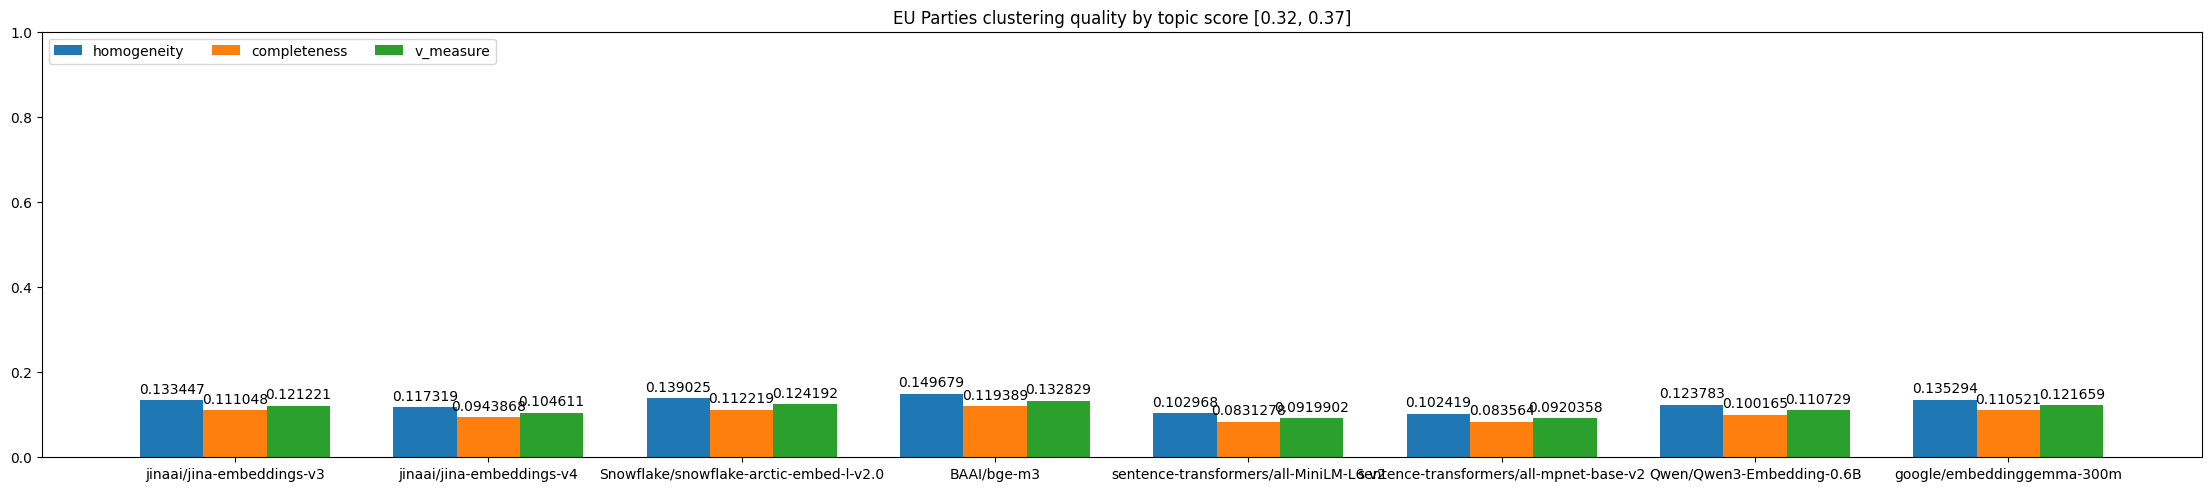

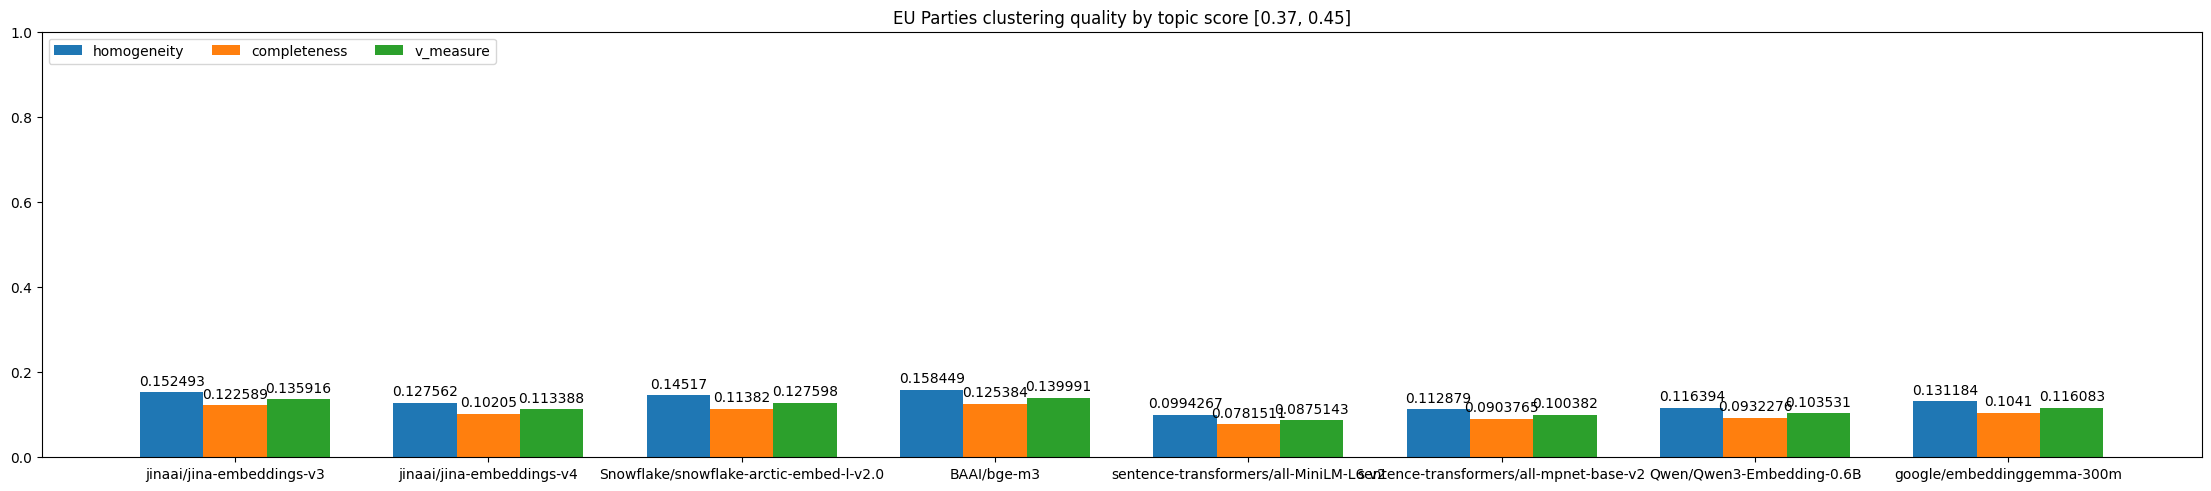

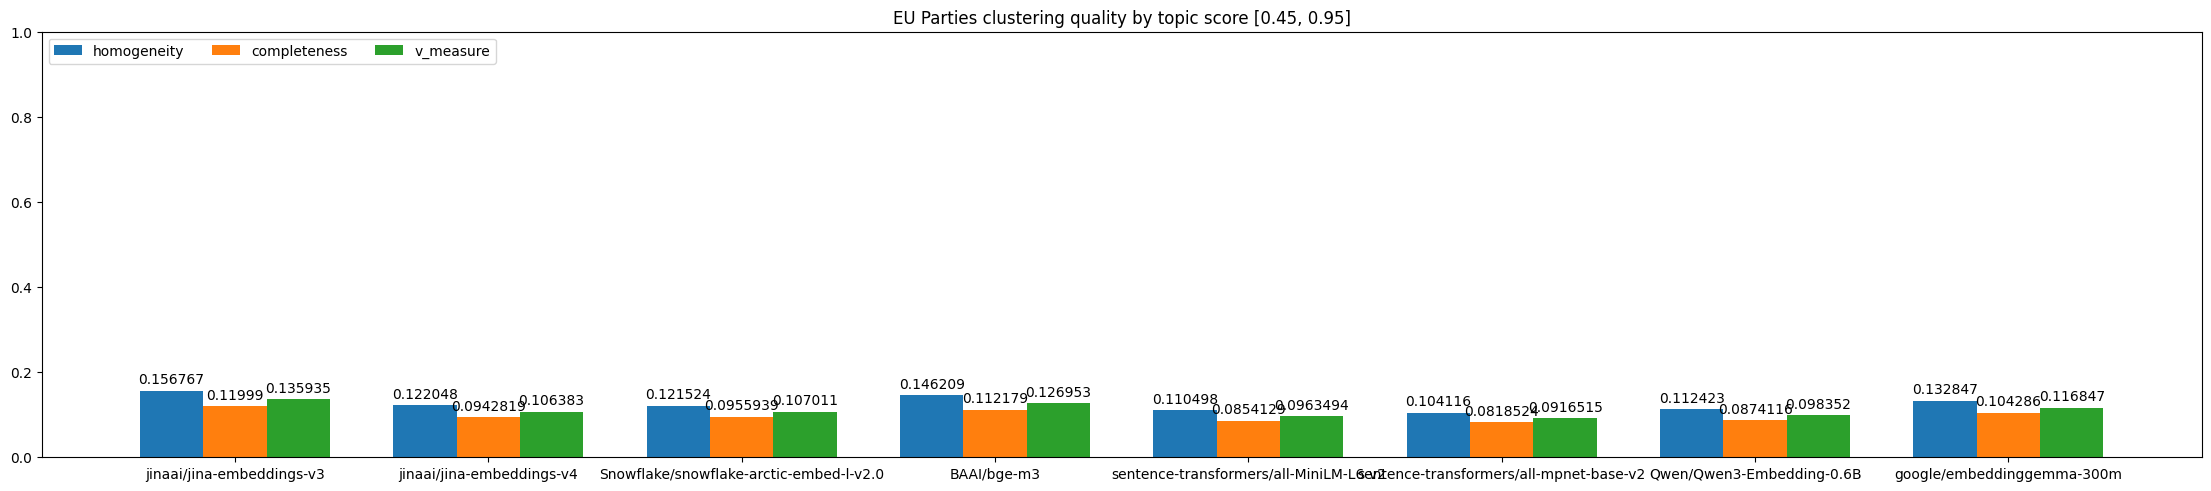

In [314]:
for quantile in range(0, 5):
    q_low = 0.2 * quantile
    q_high = 0.2 * (1 + quantile)
    topic_low, topic_high = df['topic_43'].quantile(q=q_low), df['topic_43'].quantile(q=q_high)
    subset = df[(df['topic_43'] >= topic_low) & (df['topic_43'] <= topic_high)]
    computed_metrics = []
    for model in models:
        kmeans = KMeans(n_clusters=len(subset['eu_party'].unique()), random_state=42)
        predicted_clusters = kmeans.fit_predict(np.stack(subset[model]))
        scores = evaluate_kmeans(true_labels=subset["eu_party"], cluster_labels=predicted_clusters)
        computed_metrics.append(scores)
    plot_quality(computed_metrics, f"EU Parties clustering quality by topic score [{topic_low:.2f}, {topic_high:.2f}]")

In [261]:
computed_metrics = []
subset = df[~df['national_party'].isna()]
for model in models:
    kmeans = KMeans(n_clusters=len(subset['national_party'].unique()), random_state=42)
    predicted_clusters = kmeans.fit_predict(np.stack(subset[model]))
    print(f"Model - {model}")
    scores = evaluate_kmeans(true_labels=subset["national_party"], cluster_labels=predicted_clusters)
    computed_metrics.append(scores)

Model - jinaai/jina-embeddings-v3
Homogeneity  (each cluster has mostly one class): 0.457
Completeness (each class is mostly in one cluster): 0.405
V-measure    (harmonic mean of both):             0.430
Model - jinaai/jina-embeddings-v4
Homogeneity  (each cluster has mostly one class): 0.453
Completeness (each class is mostly in one cluster): 0.399
V-measure    (harmonic mean of both):             0.424
Model - Snowflake/snowflake-arctic-embed-l-v2.0
Homogeneity  (each cluster has mostly one class): 0.465
Completeness (each class is mostly in one cluster): 0.409
V-measure    (harmonic mean of both):             0.435
Model - BAAI/bge-m3
Homogeneity  (each cluster has mostly one class): 0.455
Completeness (each class is mostly in one cluster): 0.403
V-measure    (harmonic mean of both):             0.427
Model - sentence-transformers/all-MiniLM-L6-v2
Homogeneity  (each cluster has mostly one class): 0.448
Completeness (each class is mostly in one cluster): 0.393
V-measure    (harmonic 

<Axes: title={'center': 'National parties clustering quality by models'}>

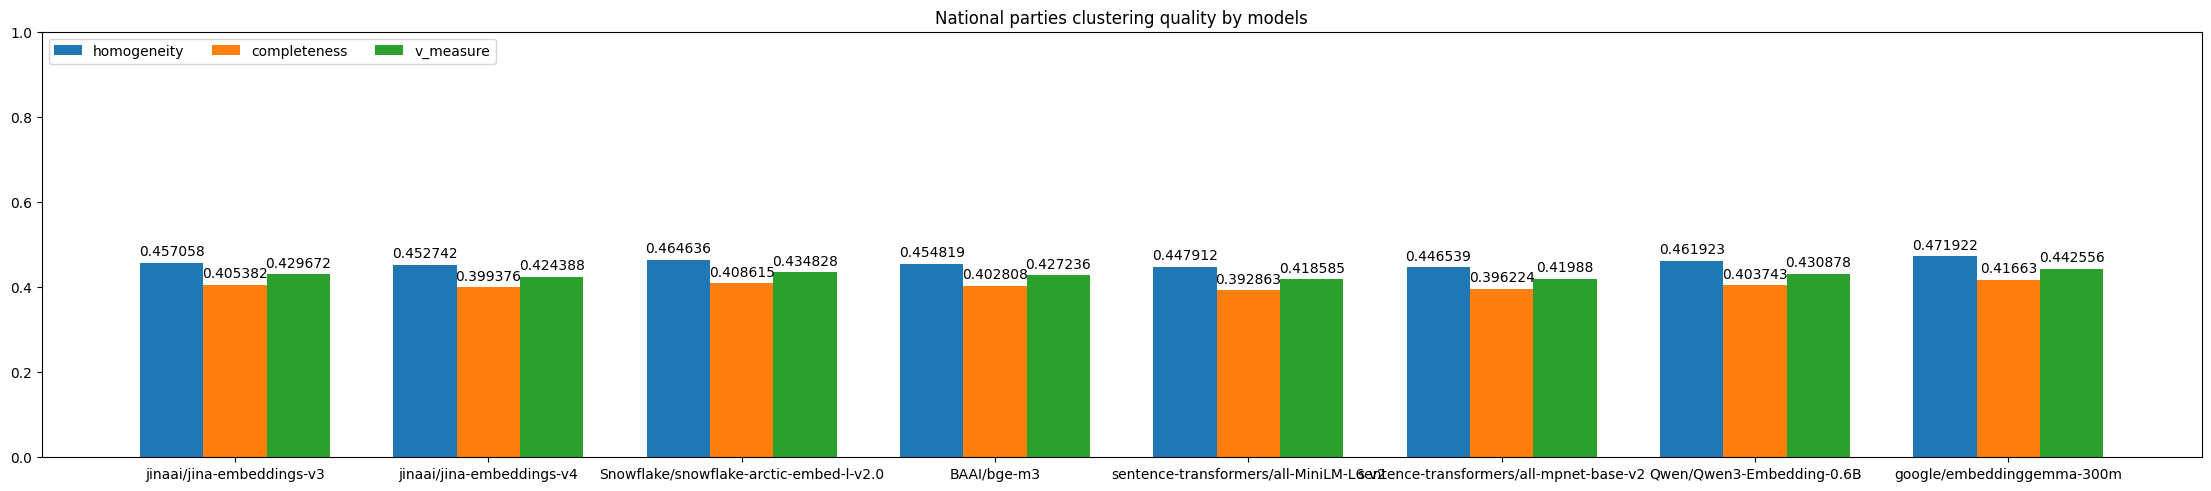

In [262]:
plot_quality(computed_metrics, "National parties clustering quality by models")

In [129]:
computed_metrics = []
for model in models:
    kmeans = KMeans(n_clusters=len(df['agenda'].unique()) // 4, random_state=42)
    predicted_clusters = kmeans.fit_predict(np.stack(df[model]))
    print(f"Model - {model}")
    scores = evaluate_kmeans(true_labels=df["agenda"], cluster_labels=predicted_clusters)
    computed_metrics.append(scores)

Model - jinaai/jina-embeddings-v3
Homogeneity  (each cluster has mostly one class): 0.602
Completeness (each class is mostly in one cluster): 0.654
V-measure    (harmonic mean of both):             0.627
Model - Snowflake/snowflake-arctic-embed-l-v2.0
Homogeneity  (each cluster has mostly one class): 0.604
Completeness (each class is mostly in one cluster): 0.657
V-measure    (harmonic mean of both):             0.629
Model - BAAI/bge-m3
Homogeneity  (each cluster has mostly one class): 0.584
Completeness (each class is mostly in one cluster): 0.642
V-measure    (harmonic mean of both):             0.611
Model - sentence-transformers/all-MiniLM-L6-v2
Homogeneity  (each cluster has mostly one class): 0.566
Completeness (each class is mostly in one cluster): 0.617
V-measure    (harmonic mean of both):             0.591
Model - sentence-transformers/all-mpnet-base-v2
Homogeneity  (each cluster has mostly one class): 0.576
Completeness (each class is mostly in one cluster): 0.629
V-measure

<Axes: title={'center': 'Agenda Items clustering quality by models'}>

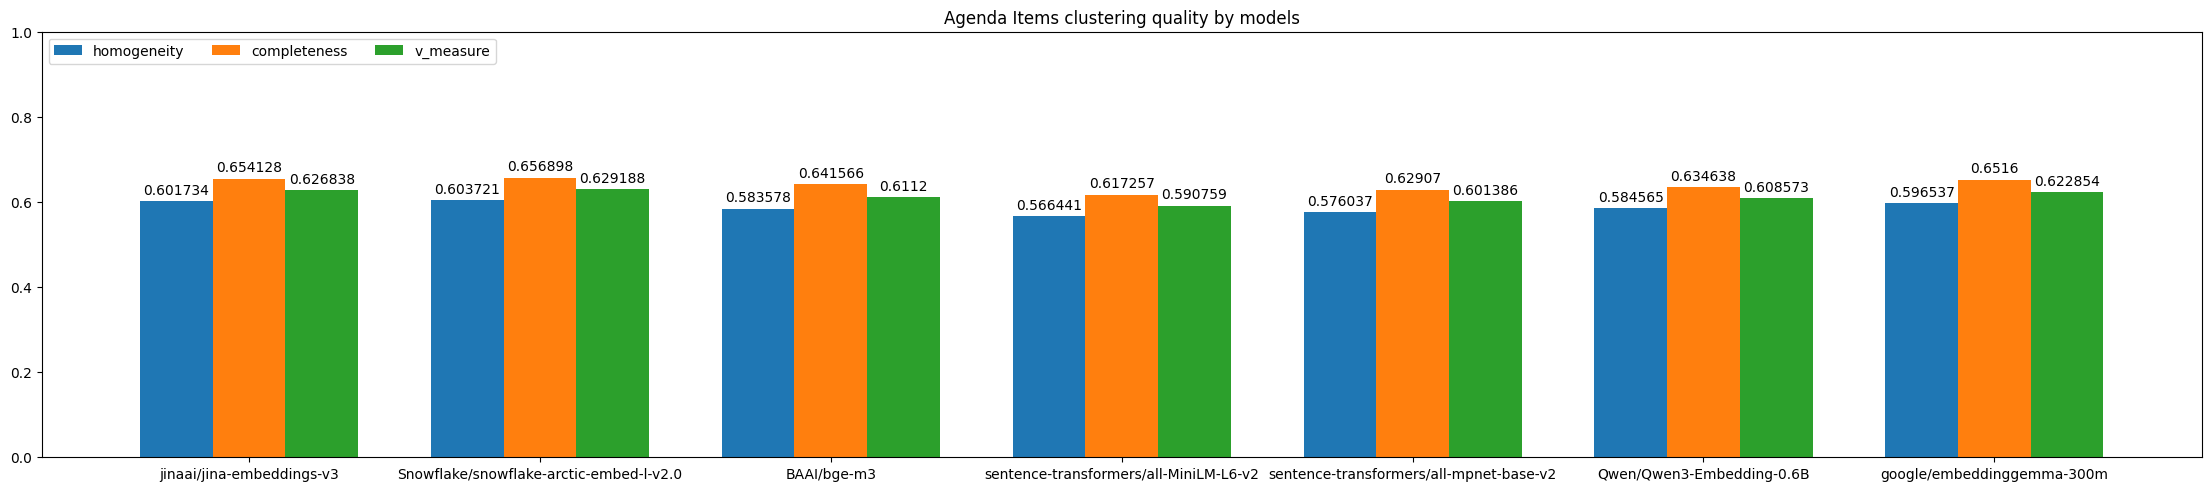

In [130]:
plot_quality(computed_metrics, "Agenda Items clustering quality by models")

In [131]:
df['text'].str.split().str.len().describe()

count    7928.000000
mean      187.951312
std       100.130697
min        11.000000
25%       133.000000
50%       178.000000
75%       222.000000
max      1024.000000
Name: text, dtype: float64

In [132]:
computed_metrics = []
subset = df[(df['text'].str.split().str.len() >= 132) & (df['text'].str.split().str.len() <= 220)]
for model in models:
    kmeans = KMeans(n_clusters=len(subset['eu_party'].unique()), random_state=42)
    predicted_clusters = kmeans.fit_predict(np.stack(subset[model]))
    print(f"Model - {model}")
    scores = evaluate_kmeans(true_labels=subset["eu_party"], cluster_labels=predicted_clusters)
    computed_metrics.append(scores)

Model - jinaai/jina-embeddings-v3
Homogeneity  (each cluster has mostly one class): 0.084
Completeness (each class is mostly in one cluster): 0.066
V-measure    (harmonic mean of both):             0.074
Model - Snowflake/snowflake-arctic-embed-l-v2.0
Homogeneity  (each cluster has mostly one class): 0.088
Completeness (each class is mostly in one cluster): 0.069
V-measure    (harmonic mean of both):             0.078
Model - BAAI/bge-m3
Homogeneity  (each cluster has mostly one class): 0.094
Completeness (each class is mostly in one cluster): 0.073
V-measure    (harmonic mean of both):             0.082
Model - sentence-transformers/all-MiniLM-L6-v2
Homogeneity  (each cluster has mostly one class): 0.054
Completeness (each class is mostly in one cluster): 0.043
V-measure    (harmonic mean of both):             0.048
Model - sentence-transformers/all-mpnet-base-v2
Homogeneity  (each cluster has mostly one class): 0.071
Completeness (each class is mostly in one cluster): 0.055
V-measure

In [133]:
party_bucket_map = {
    # Social-democratic / centre-left
    "PSE": 1,     # red – classic social-democrats
    "S&D": 1,     # modern centre-left red

    # Green / regionalist
    "Greens/EFA": 2,   # bright ecological green

    # Liberal / centrist
    "ALDE": 3,     # gold – liberal-centrist
    "ELDR": 3,     # yellow – predecessor of ALDE
    "Renew": 3,    # Renew Europe → ALDE lineage; slightly softer gold

    # Conservative / Christian-democratic / centre-right
    "PPE": 4,      # royal blue – centre-right
    "PPE-DE": 4,   # lighter center-right
    "UEN": 4,      # yellow-ish soft right/Christian-democratic

    # Right-wing Eurosceptic / conservative-nationalist
    "ECR": 5,      # deep conservative blue
    "IND/DEM": 5,  # purple – right-wing eurosceptic
    "EFD": 5,      # medium purple – eurosceptic
    "EFDD": 5,     # softer purple – populist eurosceptic
    "EDD": 5,    # violet – early eurosceptic right

    # Far-right / nationalist
    "ITS": 6,      # dark navy – far-right
    "ENF": 6,      # navy – nationalist far-right
    "ID": 6,       # earthy brown – Identity & Democracy

    # Left / far-left
    "The Left": 7, # deep dark red – consistent with GUE/NGL lineage
    "GUE/NGL": 7,  # far-left red
}



In [316]:
computed_metrics = []
for model in models:
    kmeans = KMeans(n_clusters=7, random_state=42)
    predicted_clusters = kmeans.fit_predict(np.stack(df[model]))
    print(f"Model - {model}")
    scores = evaluate_kmeans(true_labels=df["eu_party"].apply(lambda p: party_bucket_map[p]), cluster_labels=predicted_clusters)
    computed_metrics.append(scores)

Model - jinaai/jina-embeddings-v3
Model - jinaai/jina-embeddings-v4
Model - Snowflake/snowflake-arctic-embed-l-v2.0
Model - BAAI/bge-m3
Model - sentence-transformers/all-MiniLM-L6-v2
Model - sentence-transformers/all-mpnet-base-v2
Model - Qwen/Qwen3-Embedding-0.6B
Model - google/embeddinggemma-300m


<Axes: title={'center': 'Eu Party Similar ideology bucket clustering quality by models'}>

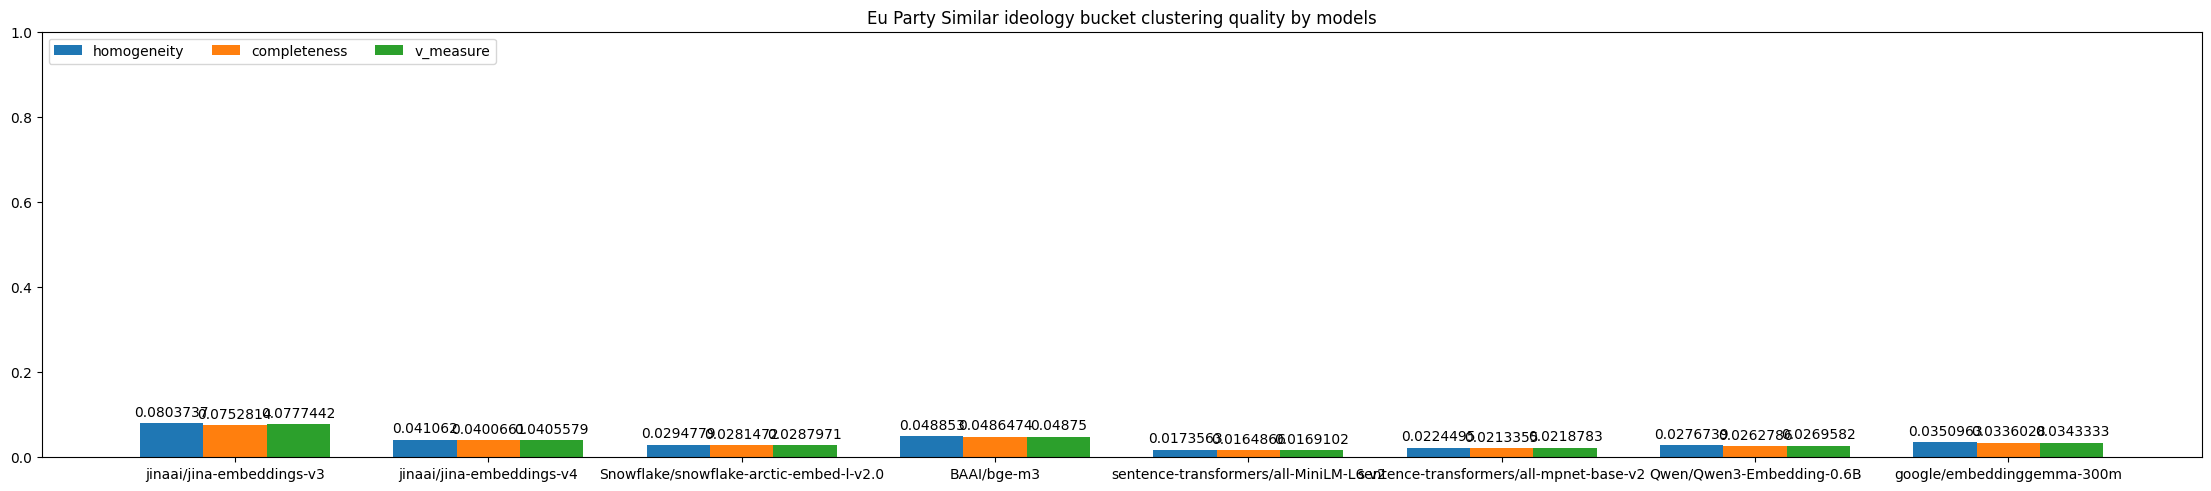

In [317]:
plot_quality(computed_metrics, "Eu Party Similar ideology bucket clustering quality by models")

In [324]:
left_right_center_map = {
    # Social-democratic / centre-left
    "PSE": -2,     # red – classic social-democrats
    "S&D": -2,     # modern centre-left red

    # Green / regionalist
    "Greens/EFA": 0,   # bright ecological green

    # Liberal / centrist
    "ALDE": -1,     # gold – liberal-centrist
    "ELDR": -1,     # yellow – predecessor of ALDE
    "Renew": -1,    # Renew Europe → ALDE lineage; slightly softer gold

    # Conservative / Christian-democratic / centre-right
    "PPE": 2,      # royal blue – centre-right
    "PPE-DE": 2,   # lighter center-right
    "UEN": 2,      # yellow-ish soft right/Christian-democratic

    # Right-wing Eurosceptic / conservative-nationalist
    "ECR": 1,      # deep conservative blue
    "IND/DEM": 1,  # purple – right-wing eurosceptic
    "EFD": 1,      # medium purple – eurosceptic
    "EFDD": 1,     # softer purple – populist eurosceptic
    "EDD": 1,    # violet – early eurosceptic right

    # Far-right / nationalist
    "ITS": 1,      # dark navy – far-right
    "ENF": 1,      # navy – nationalist far-right
    "ID": 1,       # earthy brown – Identity & Democracy

    # Left / far-left
    "The Left": -3, # deep dark red – consistent with GUE/NGL lineage
    "GUE/NGL": -3,  # far-left red
}



In [325]:
computed_metrics = []
for model in models:
    kmeans = KMeans(n_clusters=6, random_state=42)
    predicted_clusters = kmeans.fit_predict(np.stack(df[model]))
    print(f"Model - {model}")
    scores = evaluate_kmeans(true_labels=df["eu_party"].apply(lambda p: left_right_center_map[p]), cluster_labels=predicted_clusters)
    computed_metrics.append(scores)

Model - jinaai/jina-embeddings-v3
Model - jinaai/jina-embeddings-v4
Model - Snowflake/snowflake-arctic-embed-l-v2.0
Model - BAAI/bge-m3
Model - sentence-transformers/all-MiniLM-L6-v2
Model - sentence-transformers/all-mpnet-base-v2
Model - Qwen/Qwen3-Embedding-0.6B
Model - google/embeddinggemma-300m


<Axes: title={'center': 'EU Party Left-Right Wing clustering quality by models'}>

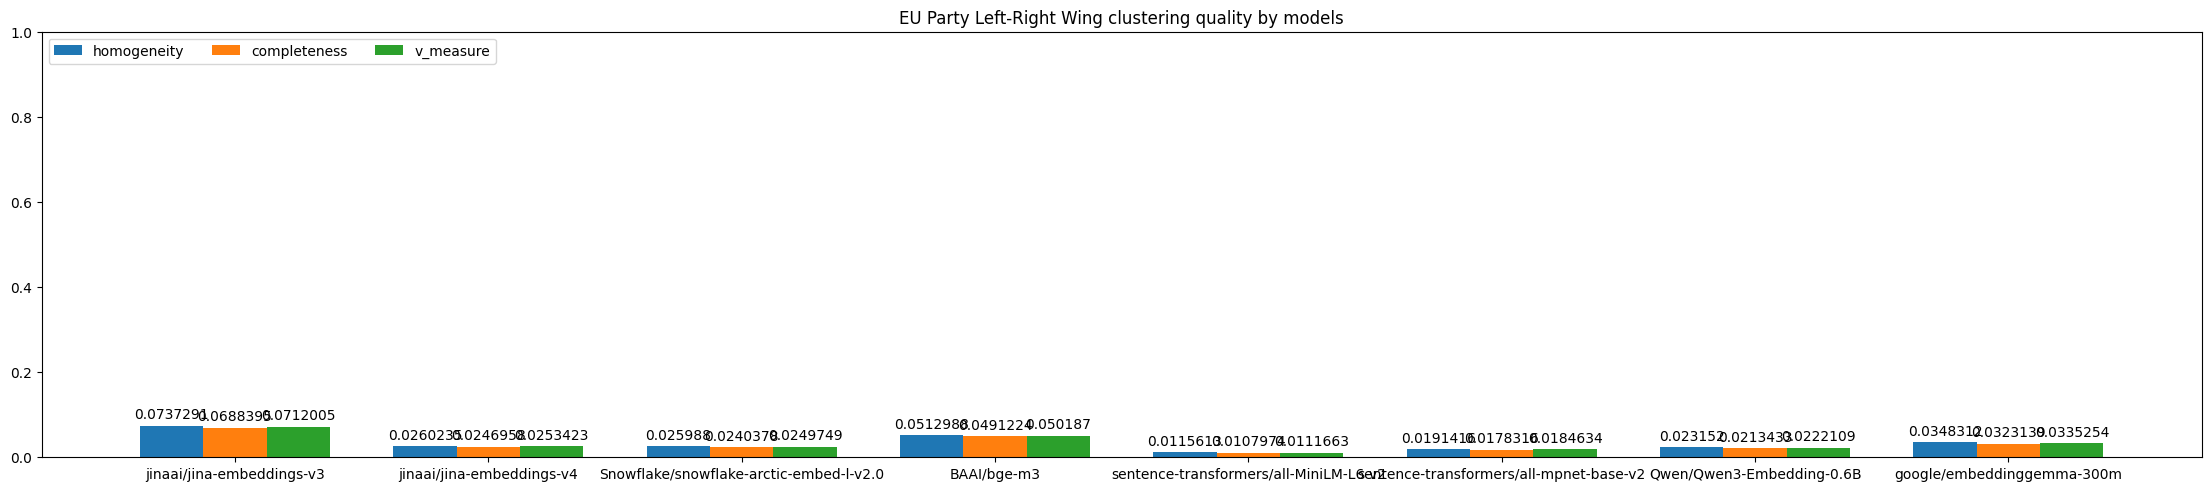

In [326]:
plot_quality(computed_metrics, "EU Party Left-Right Wing clustering quality by models")

## Measure Group Cohesiveness

In [327]:
def get_intra_inter_similarities(df, column, embedding_column):
    embeddings = np.stack(df[embedding_column])
    normalized_embeddings = embeddings / np.linalg.vector_norm(embeddings, axis=1, ord=2, keepdims=True)
    similarities = normalized_embeddings @ normalized_embeddings.T
    classes = df[column].unique()
    results = []

    for class_ in classes:
        intra = similarities[df[column] == class_][:, df[column] == class_].mean()
        inter = similarities[df[column] == class_][:, df[column] != class_].mean()
        results.append({'class': class_, 'intra': intra, 'inter': inter, 'size': sum(df[column] == class_)})
    return pd.DataFrame(results)

In [328]:
get_intra_inter_similarities(df, 'eu_party', models[0])['intra']

0     0.670066
1     0.627470
2     0.671500
3     0.708102
4     0.651847
5     0.697008
6     0.723354
7     0.665361
8     0.630399
9     0.700945
10    0.636080
11    0.644696
12    0.643410
13    0.592885
14    0.607912
15    0.612905
16    0.697688
17    0.704577
18    0.709283
Name: intra, dtype: float32

In [329]:
def plot_similarities(computed_metrics, title='Clustering quality by models'):
    fig, ax = plt.subplots(layout='constrained')
    fig.set_figwidth(22)
    x = np.arange(len(models))  # the label locations
    width = 0.33  # the width of the bars
    multiplier = 0

    metrics = {metric: [metrics[metric] for metrics in computed_metrics] for metric in  computed_metrics[0].keys()}

    for attribute, measurement in metrics.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_ylim([0, 1.])
    ax.set_title(title)
    ax.set_xticks(x + width / 2, models)
    ax.legend(loc='upper left', ncols=2)
    return ax


In [330]:
similaritiy_metrics = []
for model in models:
    similarities = get_intra_inter_similarities(df, 'eu_party', model)
    similaritiy_metrics.append({"Intra Group Similarity": similarities['intra'].mean(), "Inter Group Similarity": similarities['inter'].mean()})

<Axes: title={'center': 'EU Inter- and Intraparty similarities'}>

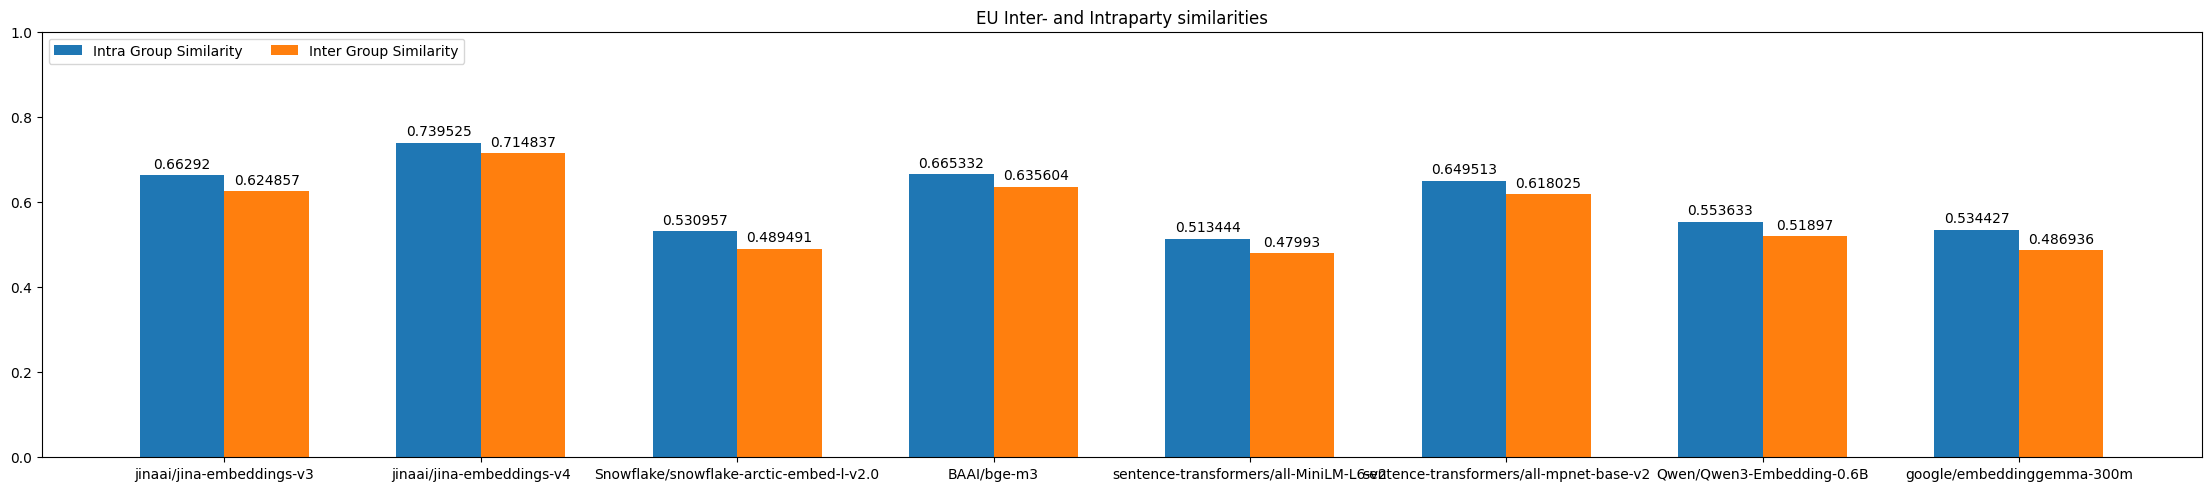

In [331]:
plot_similarities(similaritiy_metrics, "EU Inter- and Intraparty similarities")

In [332]:
similaritiy_metrics = []
for model in models:
    similarities = get_intra_inter_similarities(df[~df['national_party'].isna()], 'national_party', model)
    similaritiy_metrics.append({"Intra Group Similarity": similarities['intra'].mean(), "Inter Group Similarity": similarities['inter'].mean()})

<Axes: title={'center': 'National Inter- and Intraparty similarities'}>

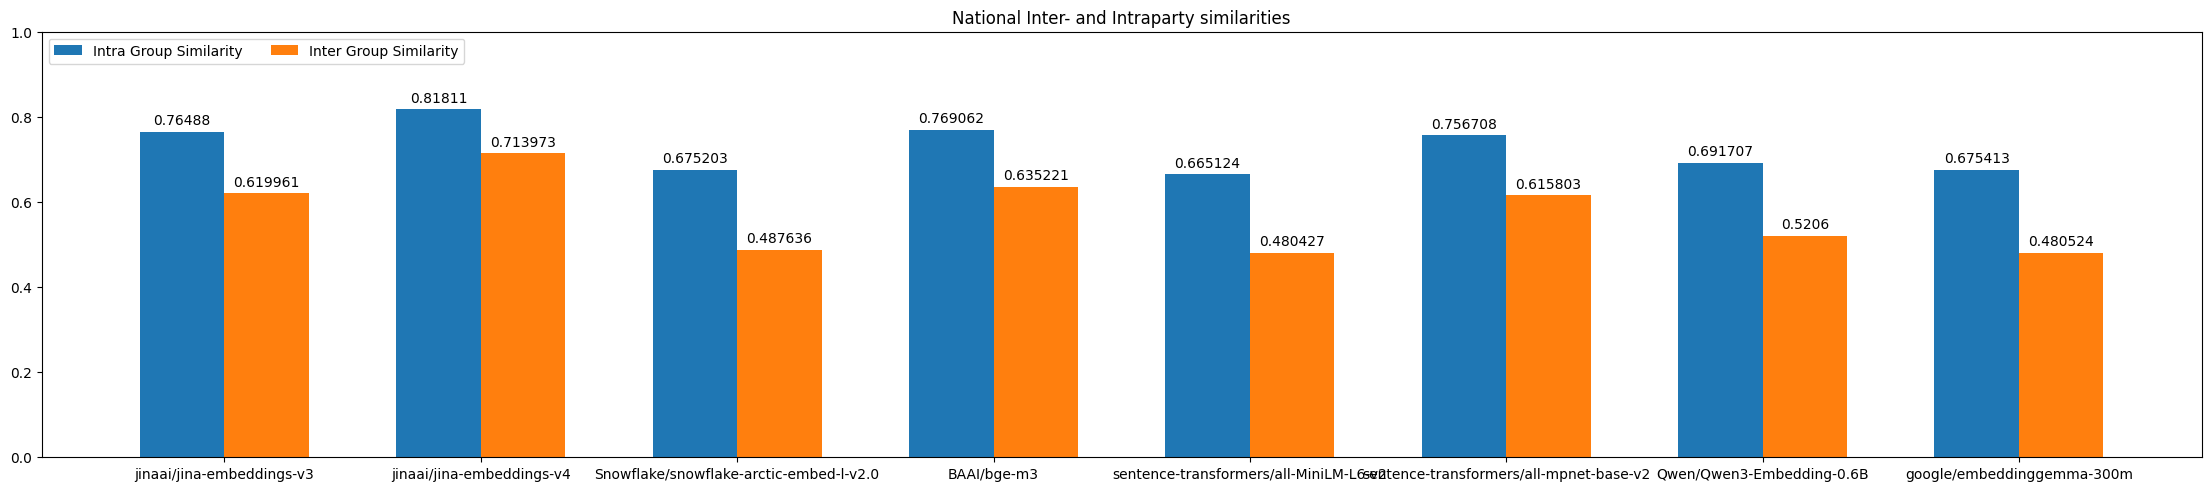

In [333]:
plot_similarities(similaritiy_metrics, "National Inter- and Intraparty similarities")

In [146]:
df.columns

Index(['speaker', 'text', 'eu_party', 'date', 'agenda', 'speechnumber',
       'period', 'national_party', 'country', 'jinaai/jina-embeddings-v3',
       'Snowflake/snowflake-arctic-embed-l-v2.0', 'BAAI/bge-m3',
       'sentence-transformers/all-MiniLM-L6-v2',
       'sentence-transformers/all-mpnet-base-v2', 'Qwen/Qwen3-Embedding-0.6B',
       'google/embeddinggemma-300m'],
      dtype='object')

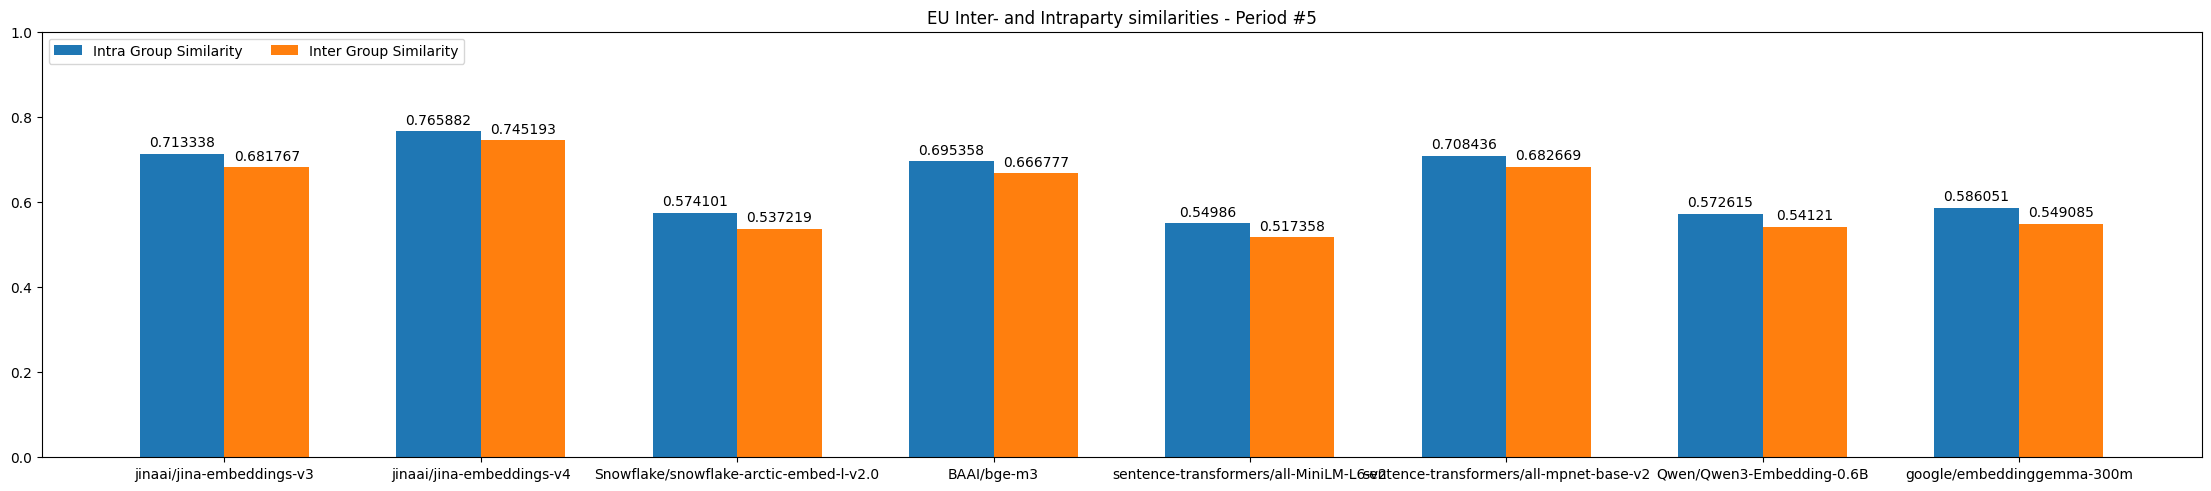

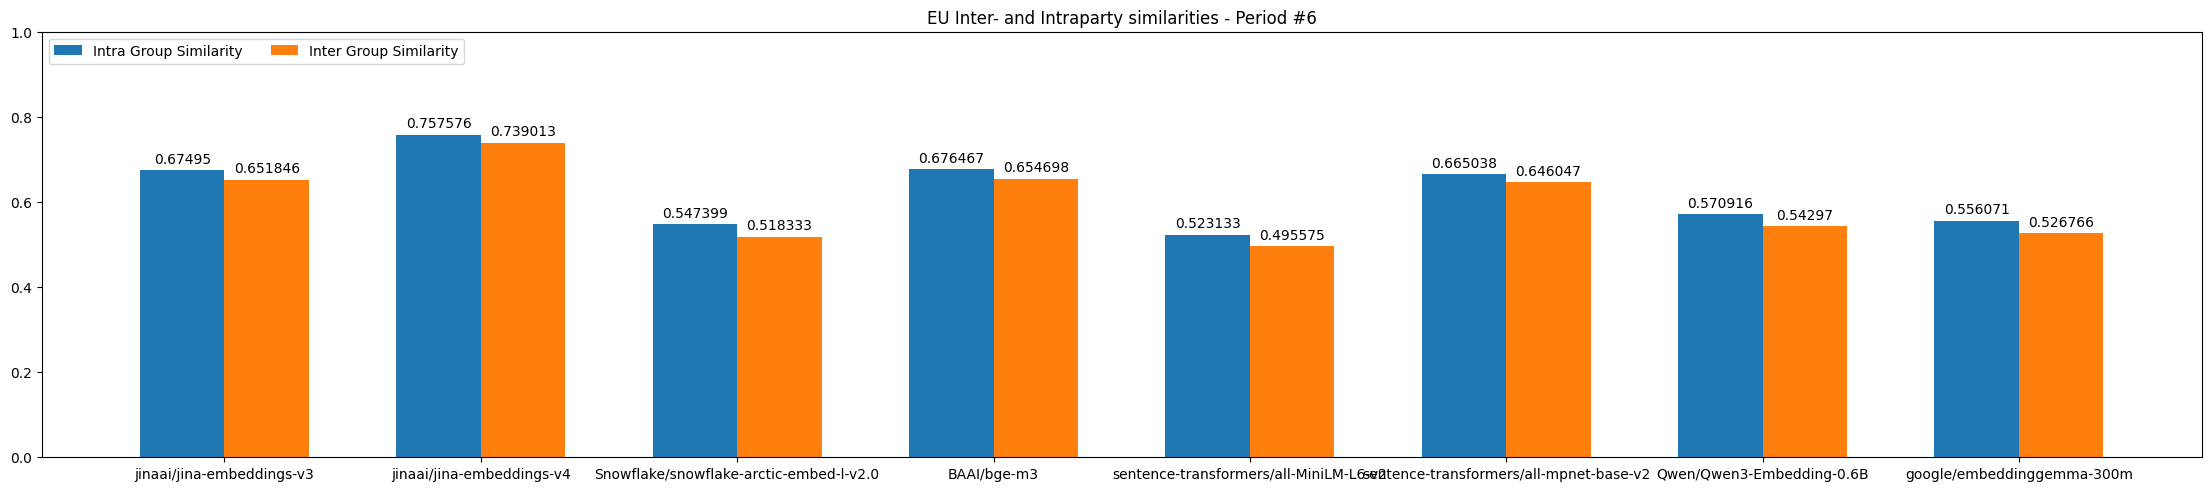

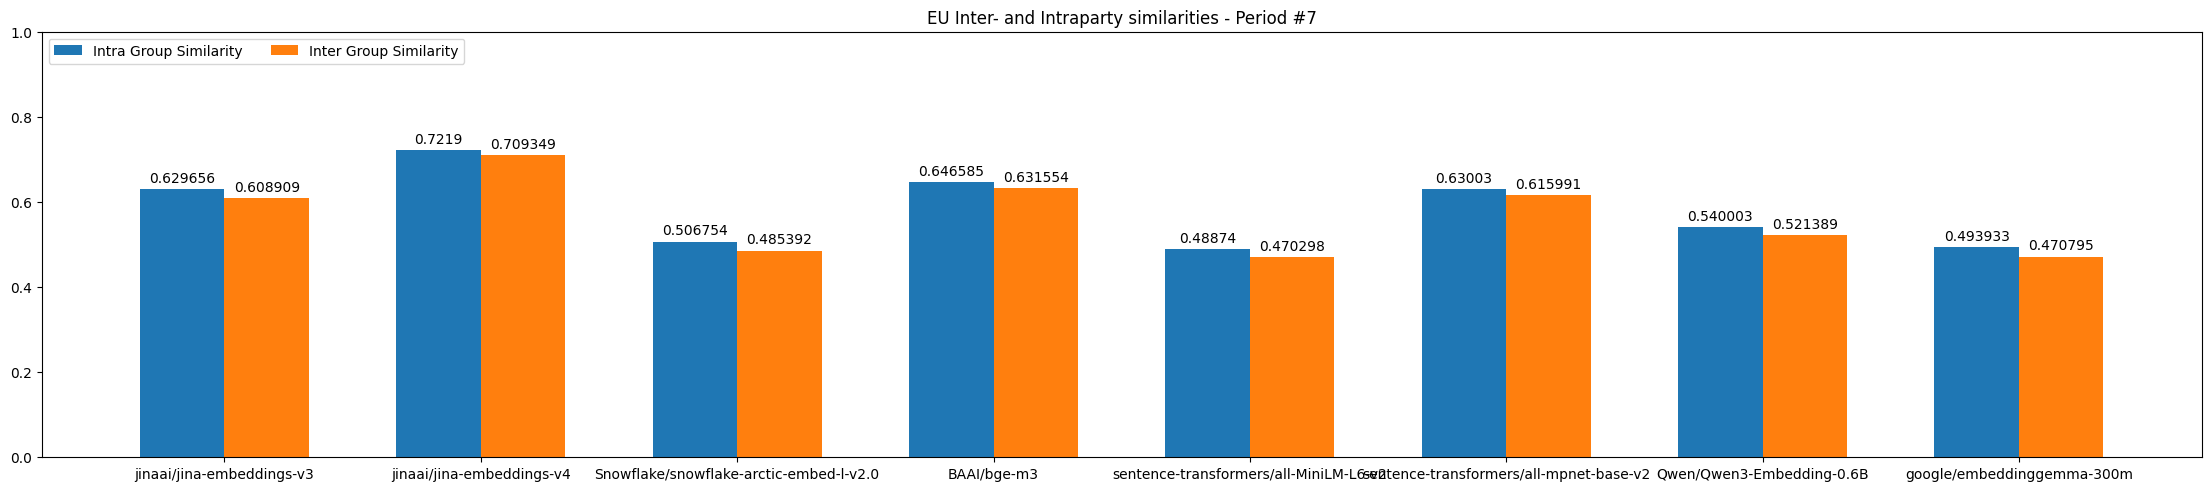

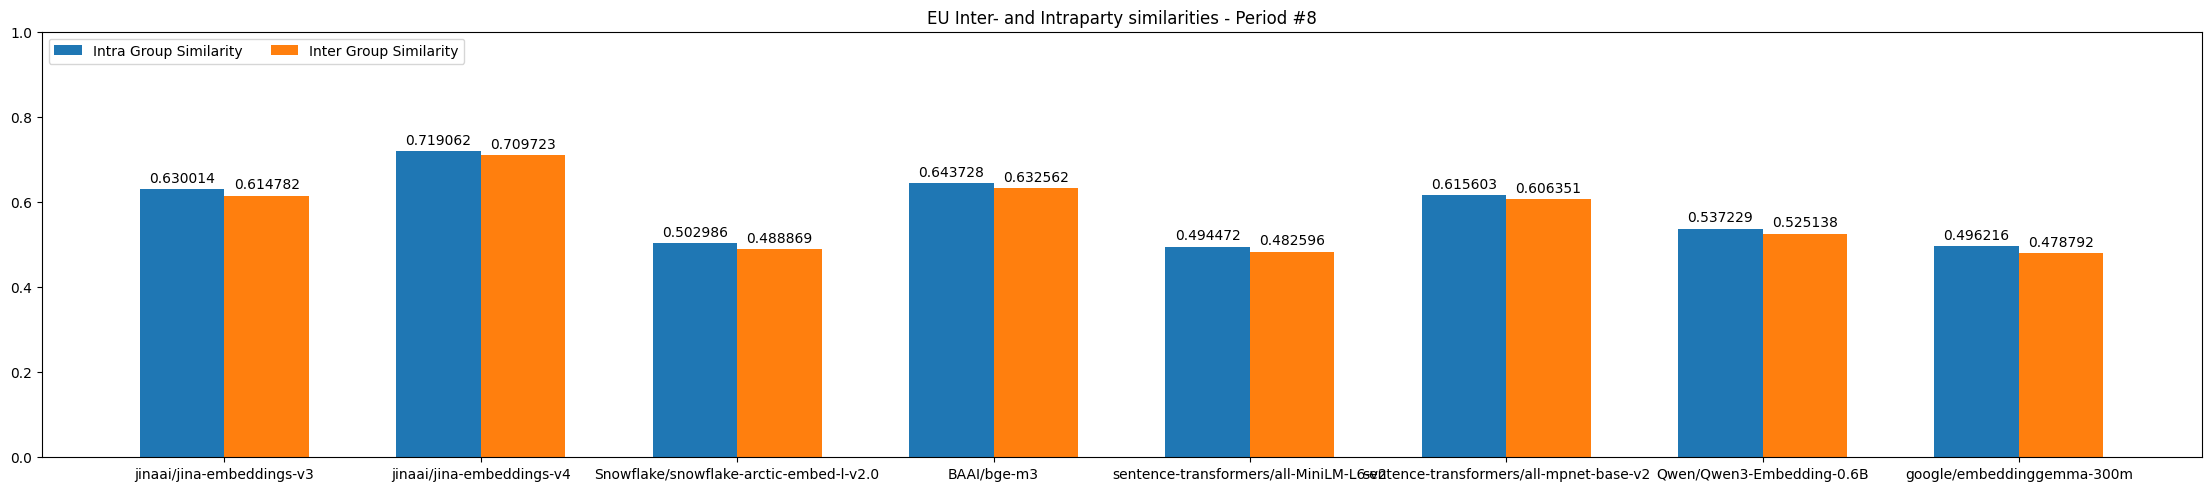

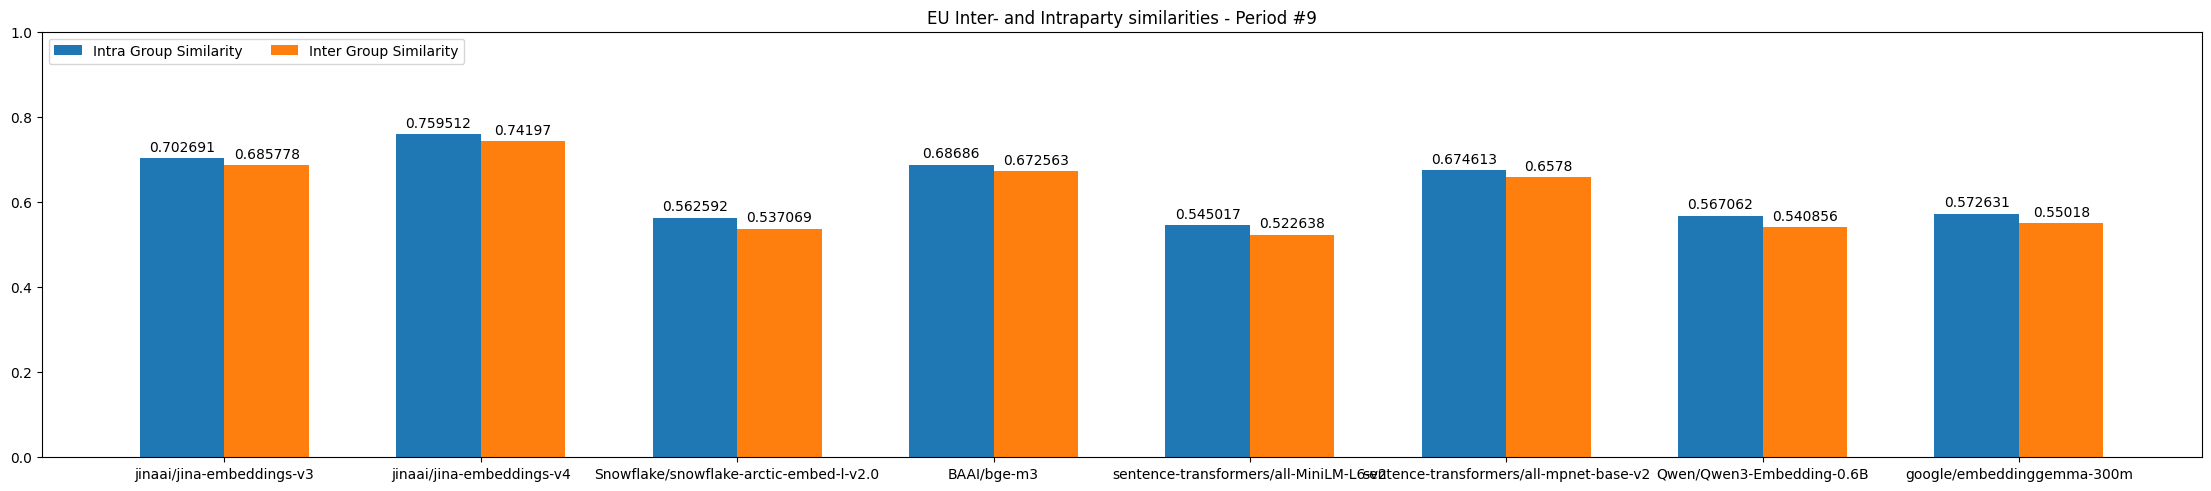

In [334]:
for period in set(df['period'].unique()):
    similaritiy_metrics = []
    for model in models:
        similarities = get_intra_inter_similarities(df[df['period'] == period], 'eu_party', model)
        similaritiy_metrics.append({"Intra Group Similarity": similarities['intra'].mean(), "Inter Group Similarity": similarities['inter'].mean()})
    plot_similarities(similaritiy_metrics, f"EU Inter- and Intraparty similarities - Period #{period}")

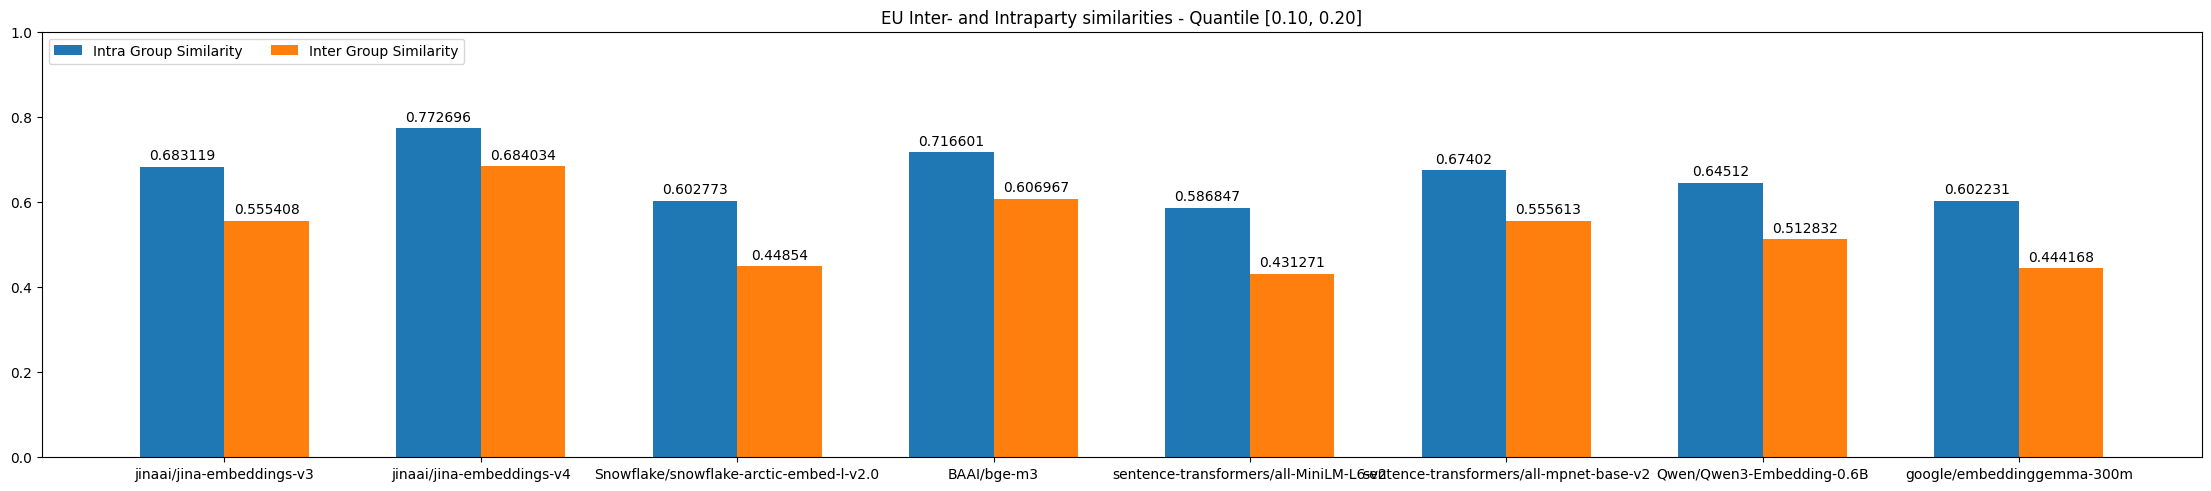

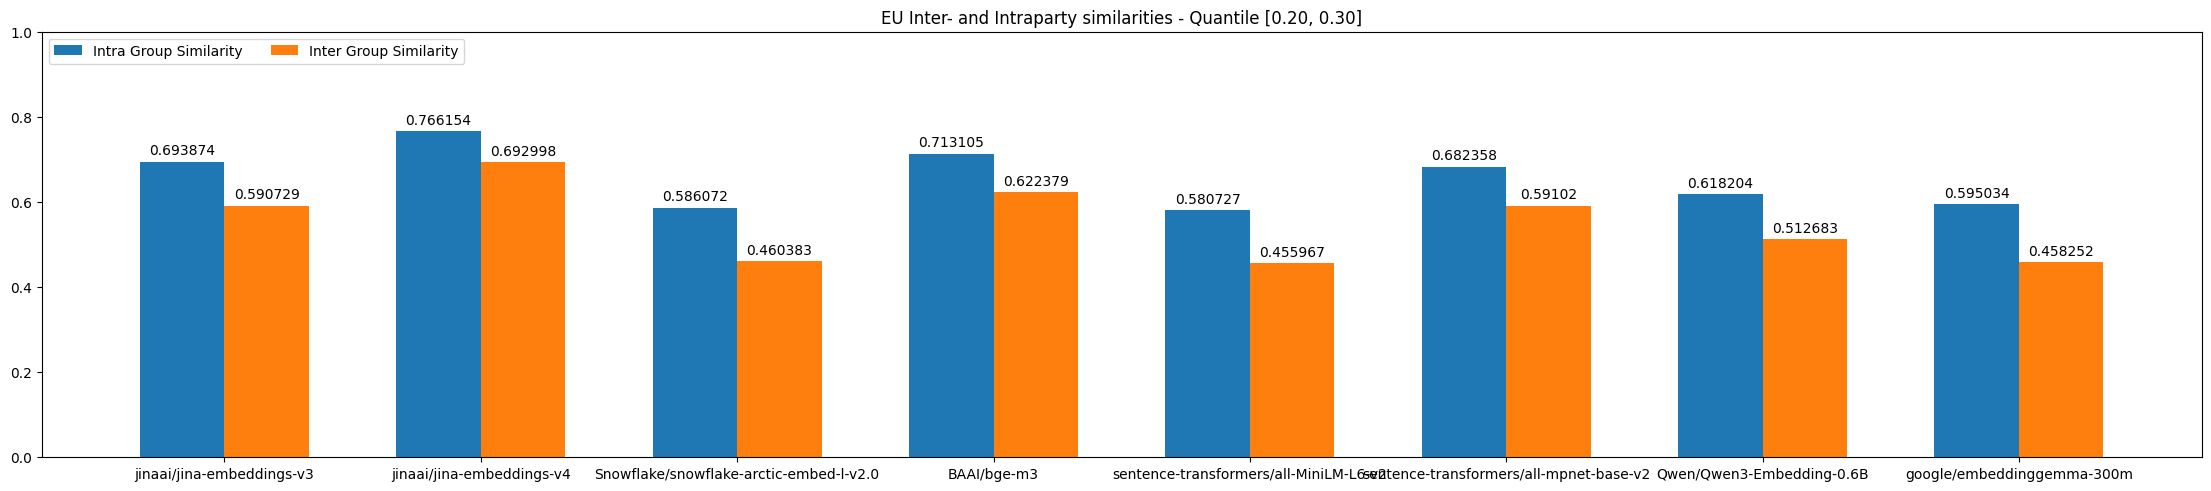

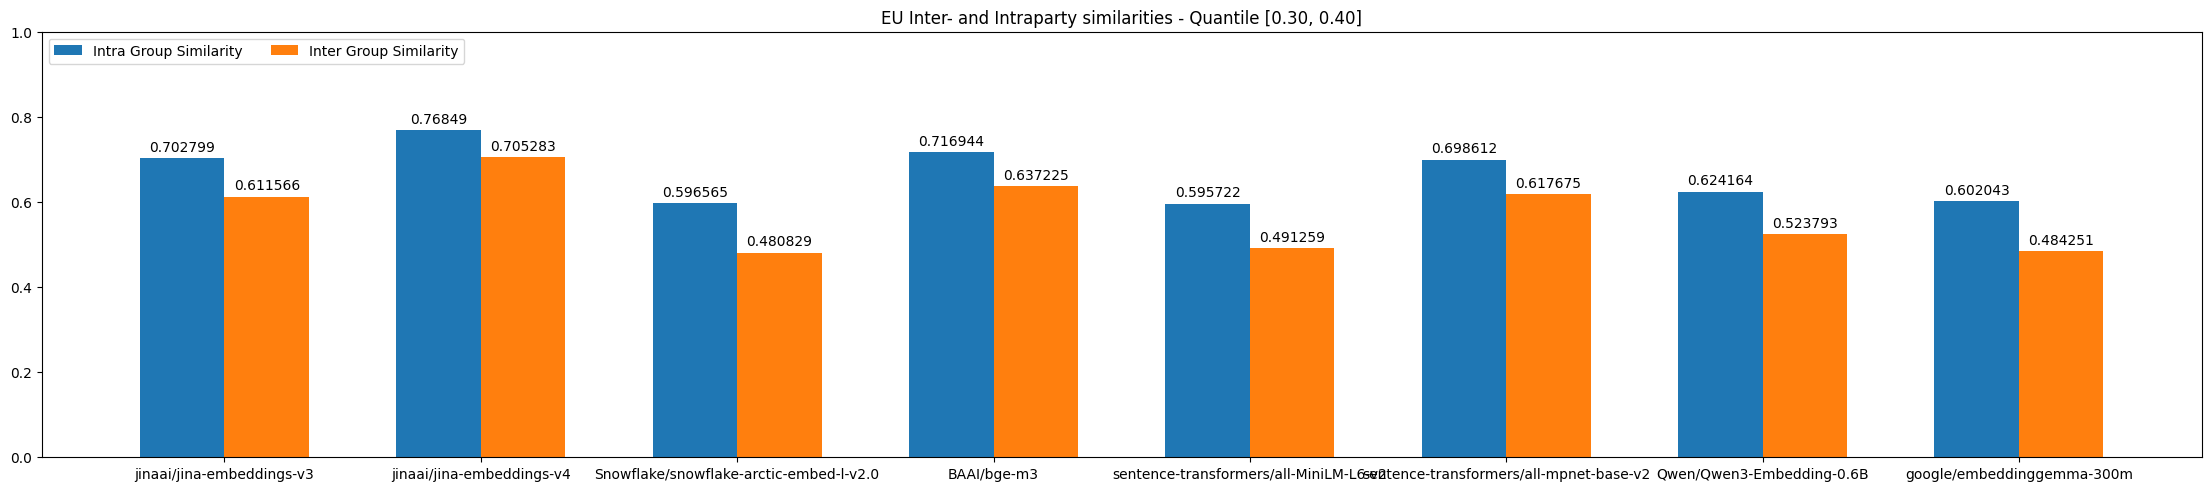

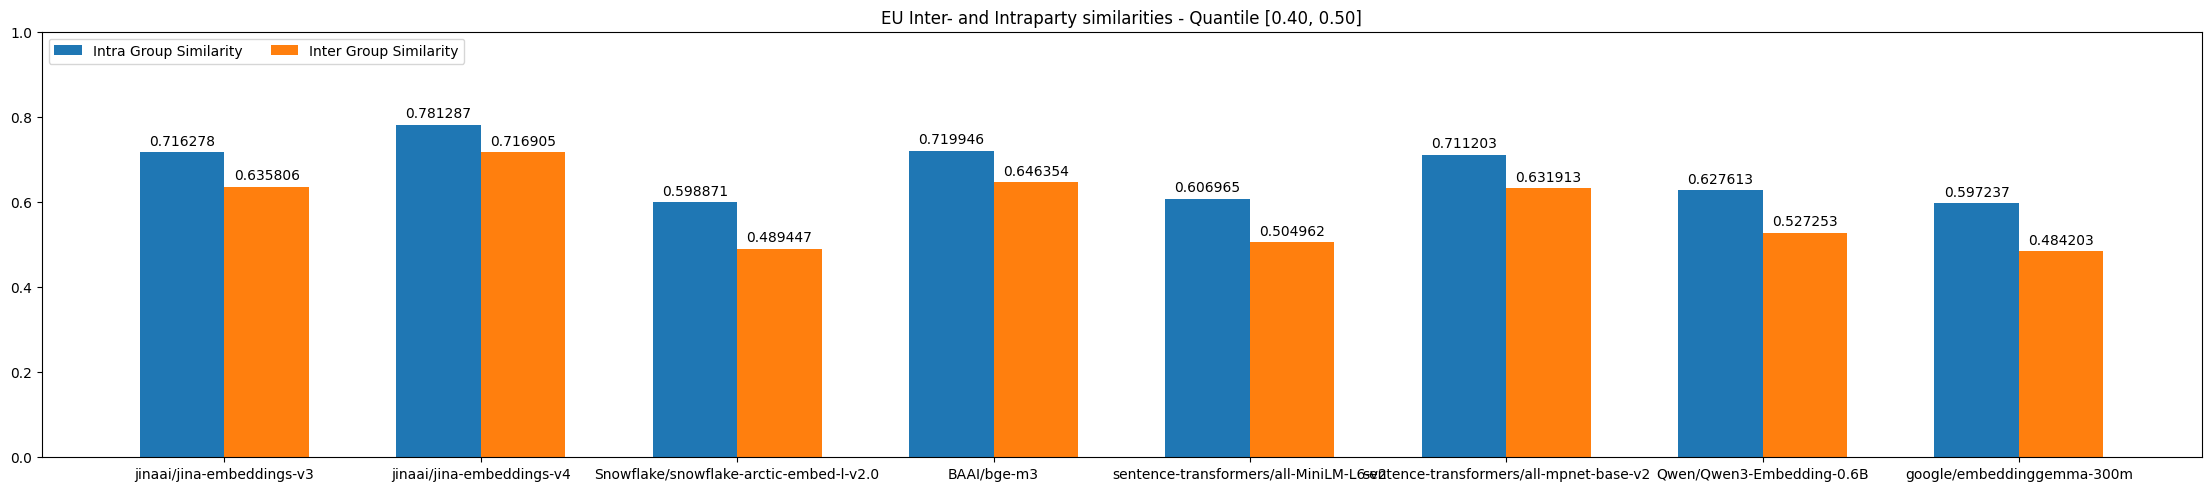

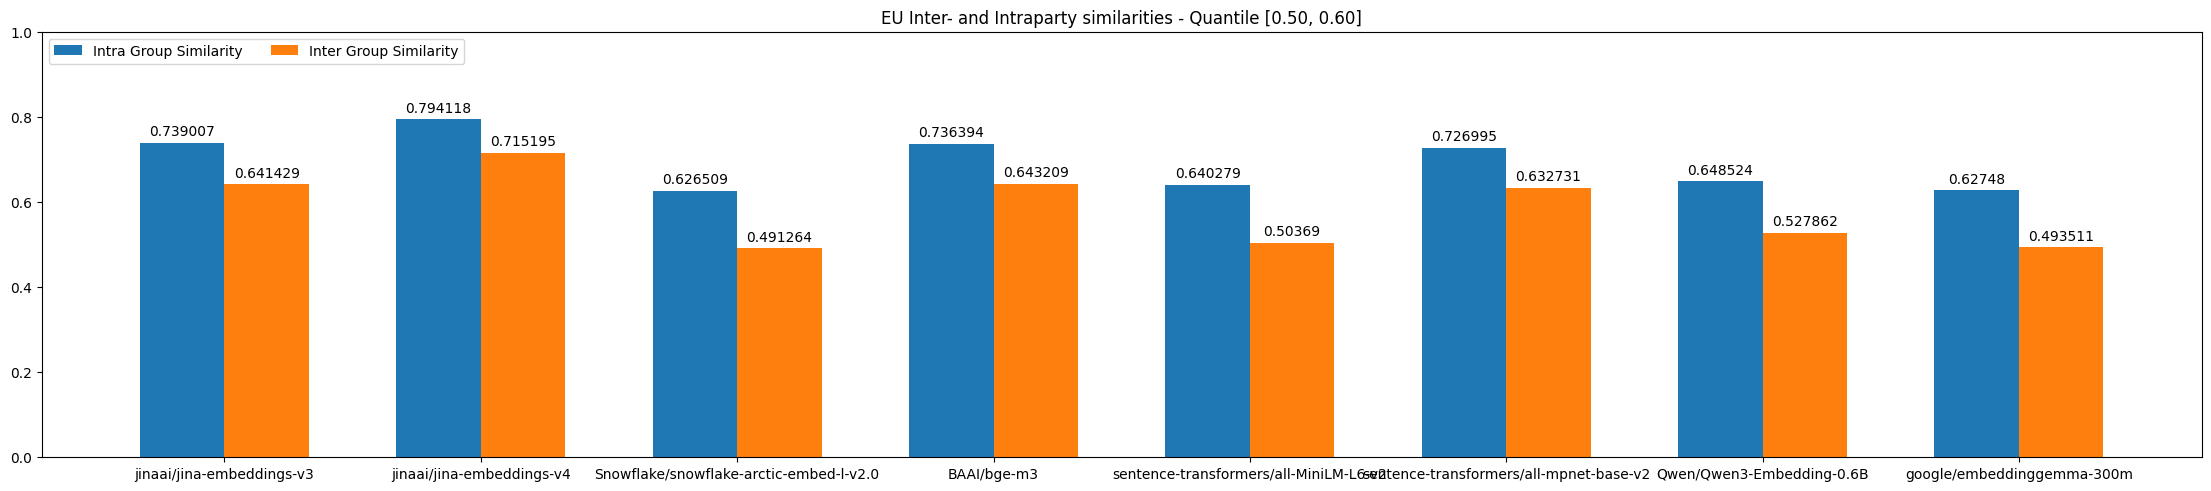

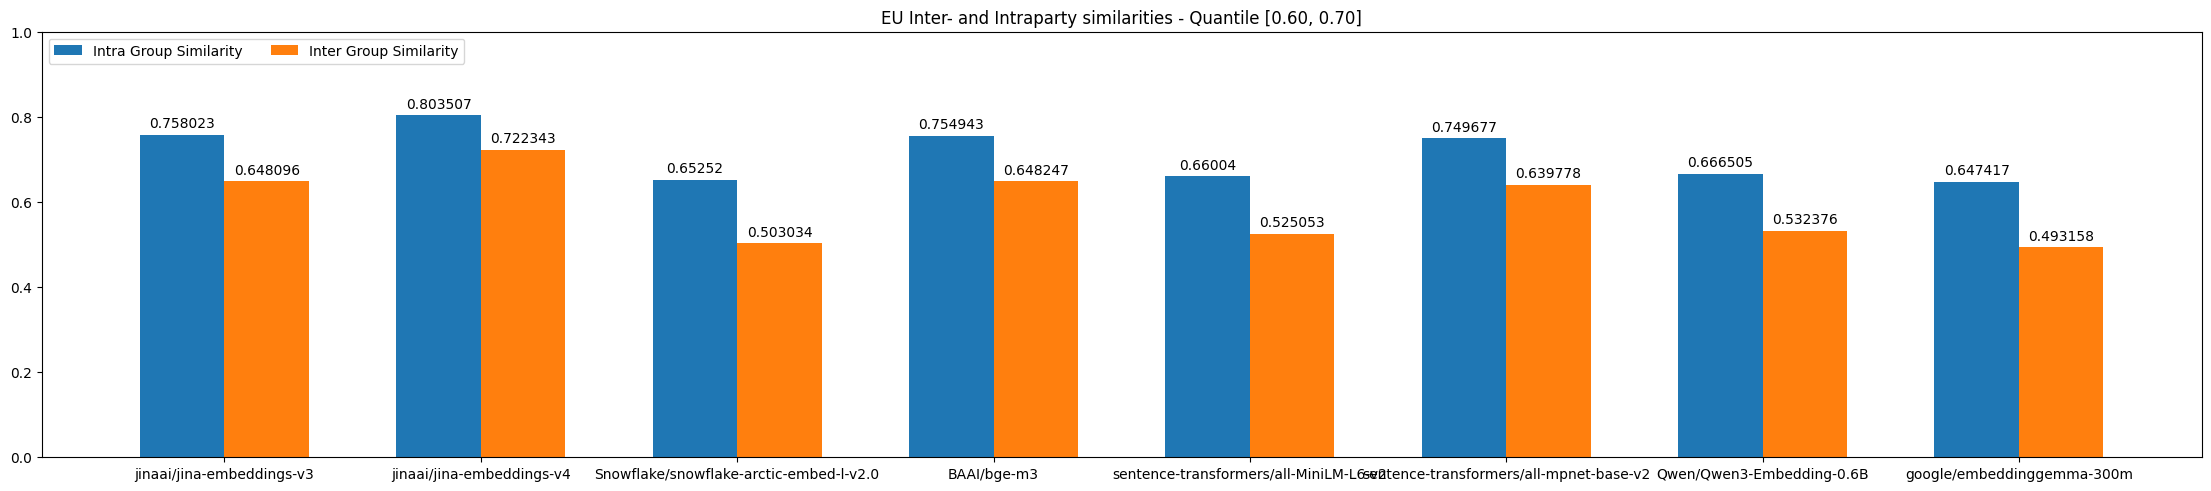

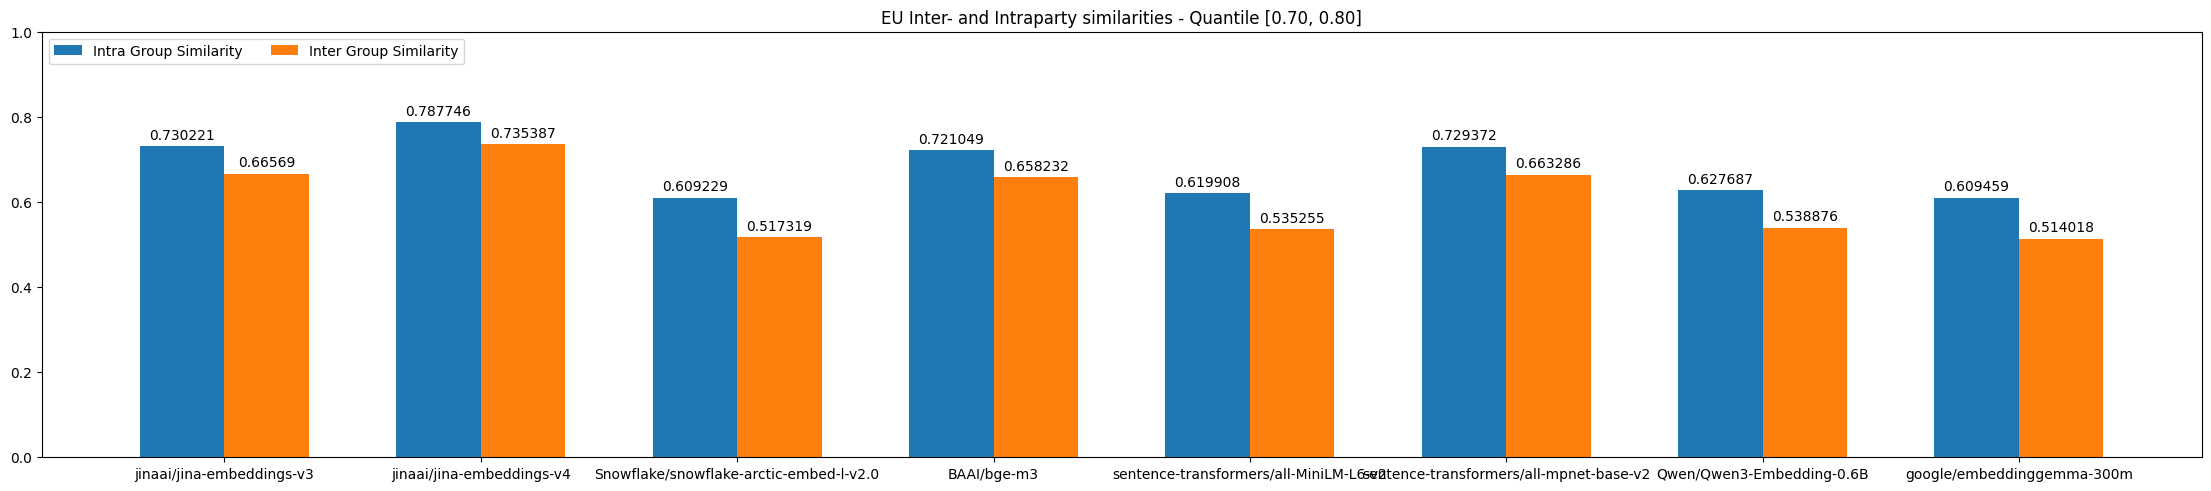

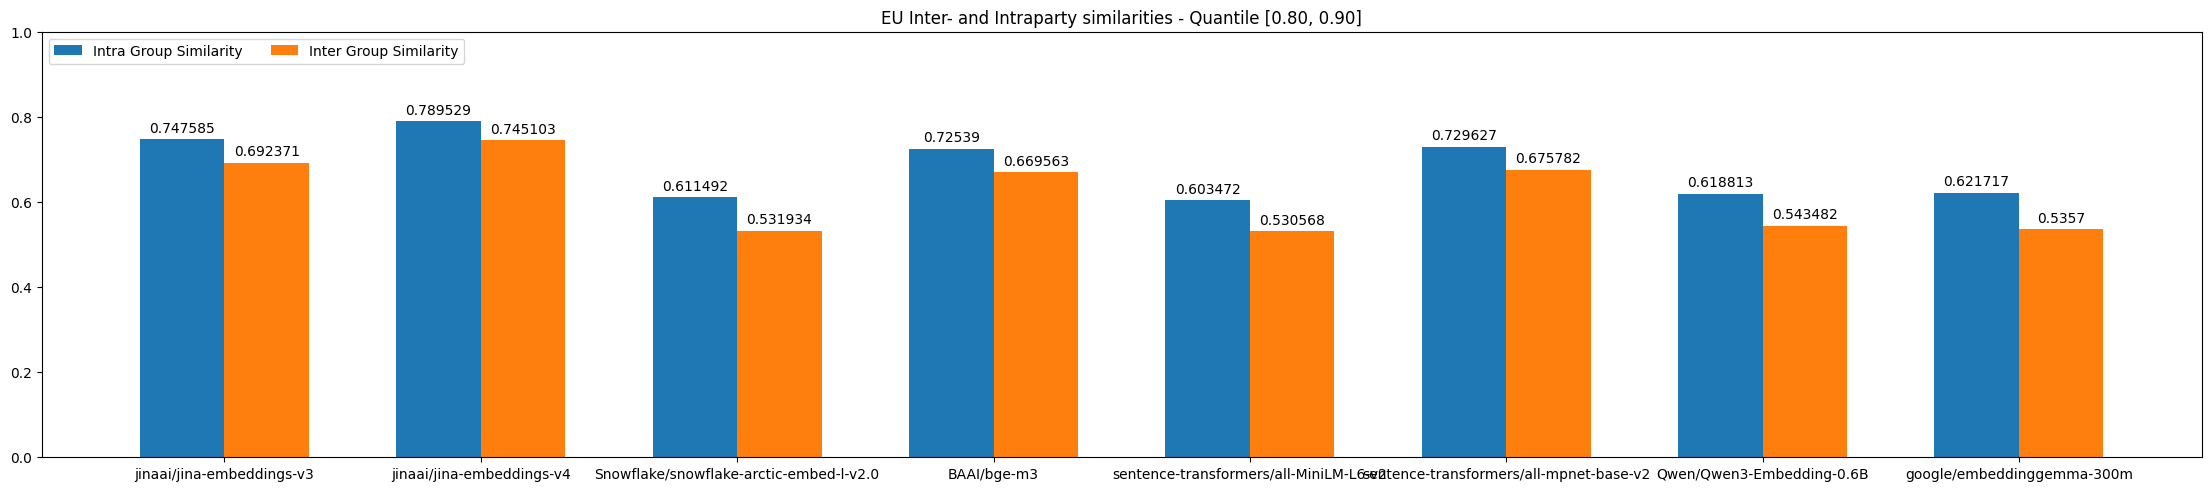

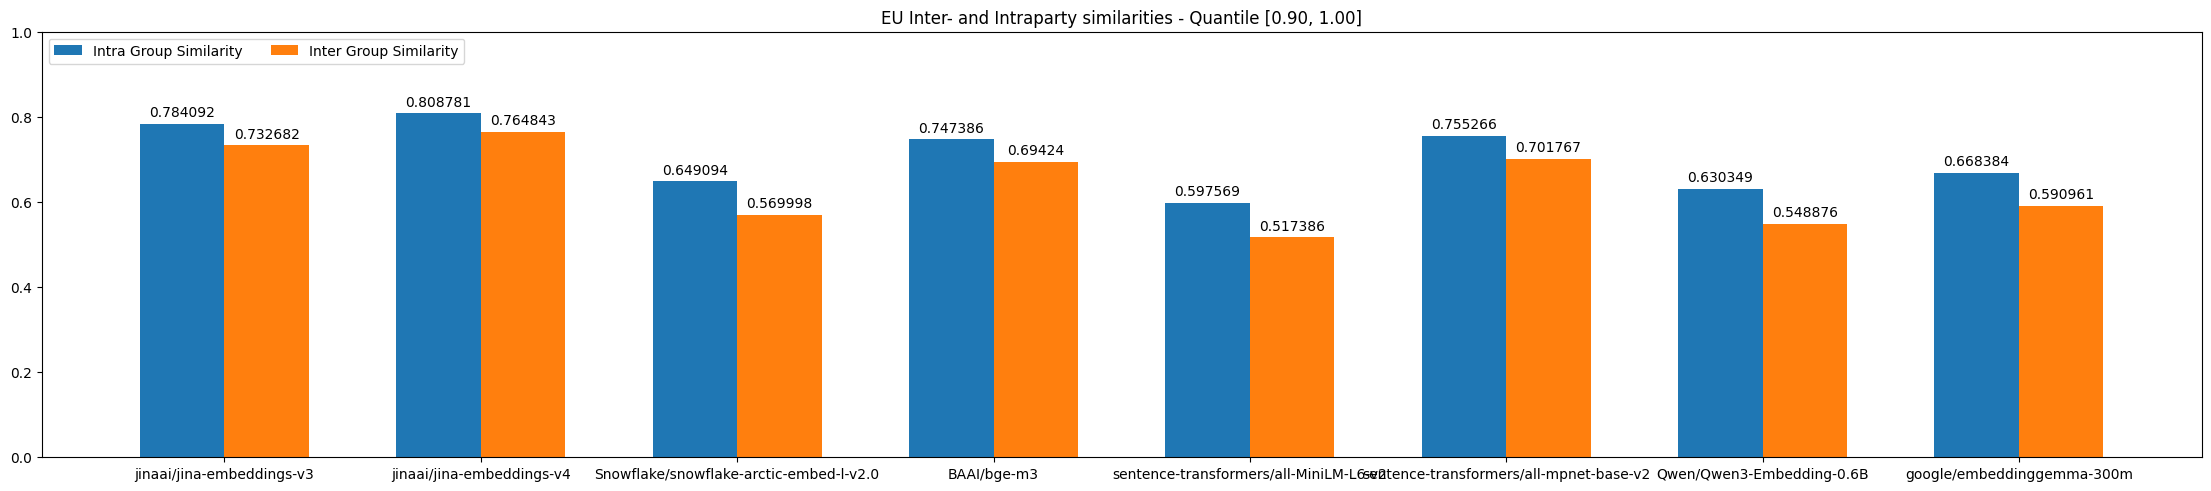

In [336]:
for quantile in range(1, 10):
    q_low = 0.1 * quantile
    q_high = 0.1 * (1 + quantile)
    length_low, length_high = df['text'].str.len().quantile(q=q_low), df['text'].str.len().quantile(q=q_high)
    similaritiy_metrics = []
    for model in models:
        similarities = get_intra_inter_similarities(df[(df['text'].str.len() >= length_low) & (df['text'].str.len() <= length_high)], 'eu_party', model)
        similaritiy_metrics.append({"Intra Group Similarity": similarities['intra'].mean(), "Inter Group Similarity": similarities['inter'].mean()})
    plot_similarities(similaritiy_metrics, f"EU Inter- and Intraparty similarities - Quantile [{q_low:.2f}, {q_high:.2f}]")

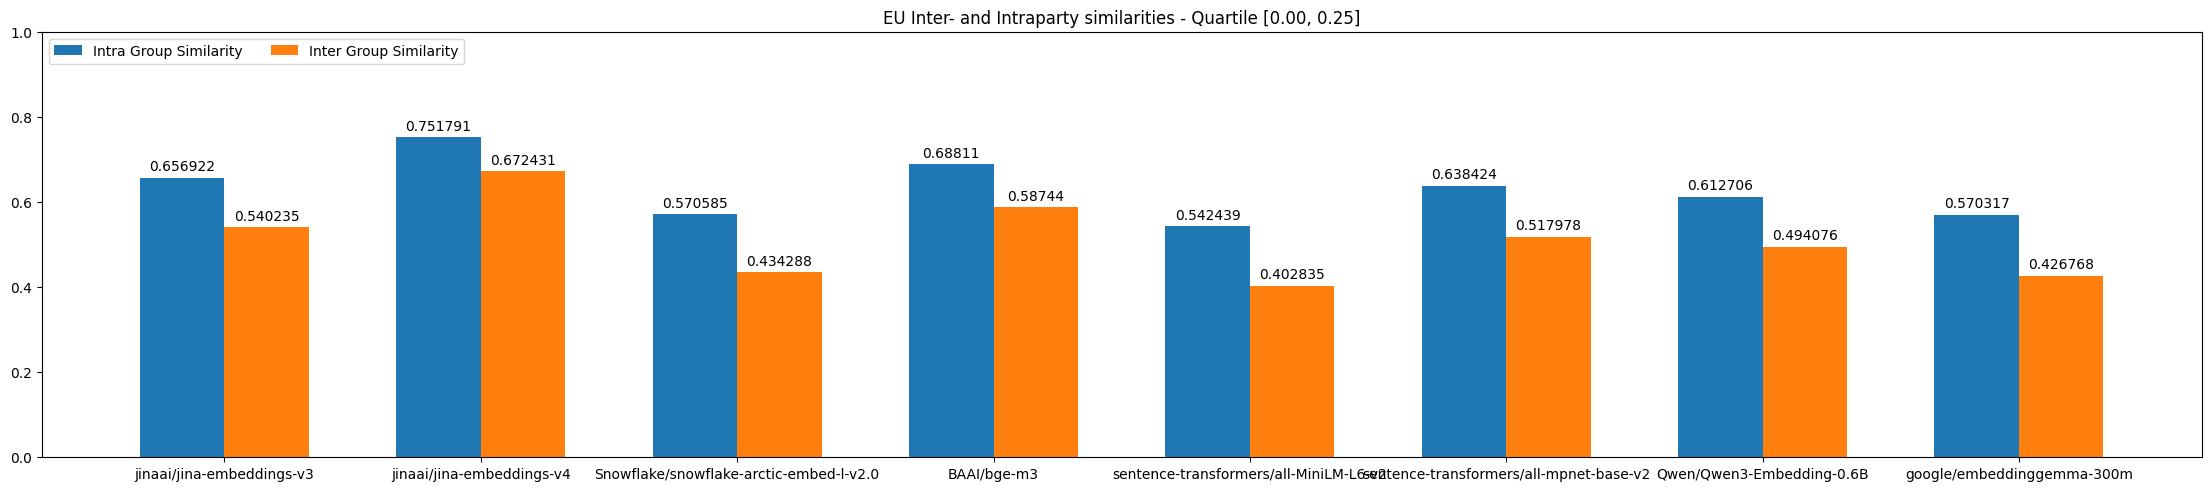

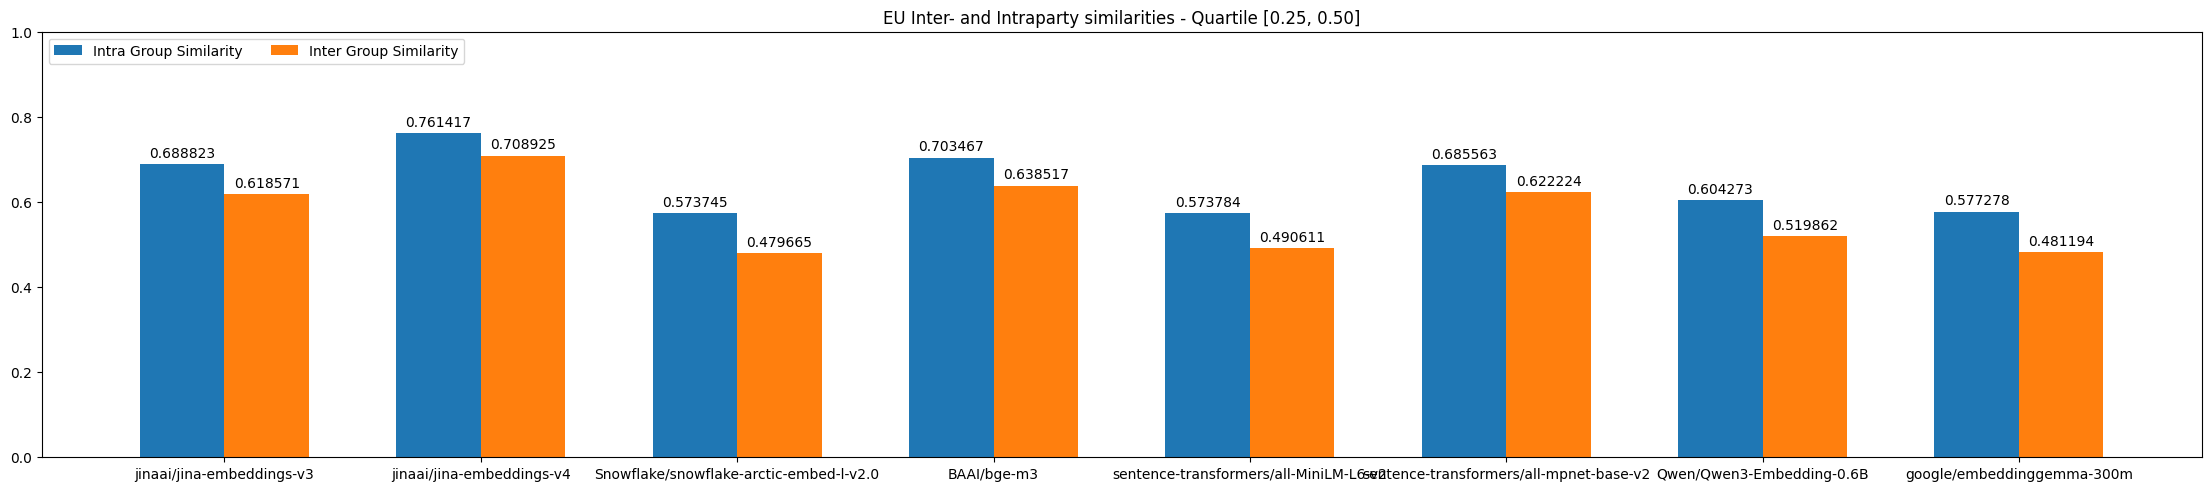

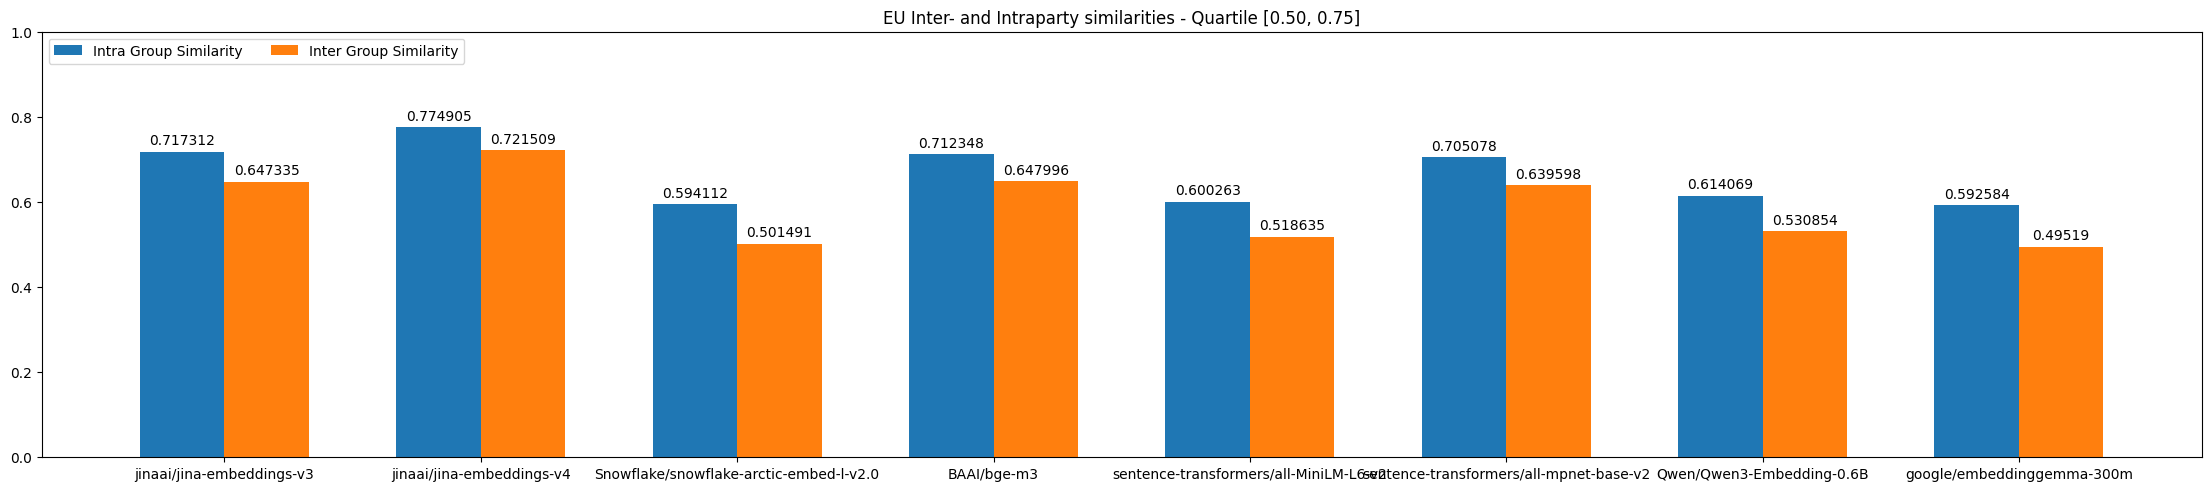

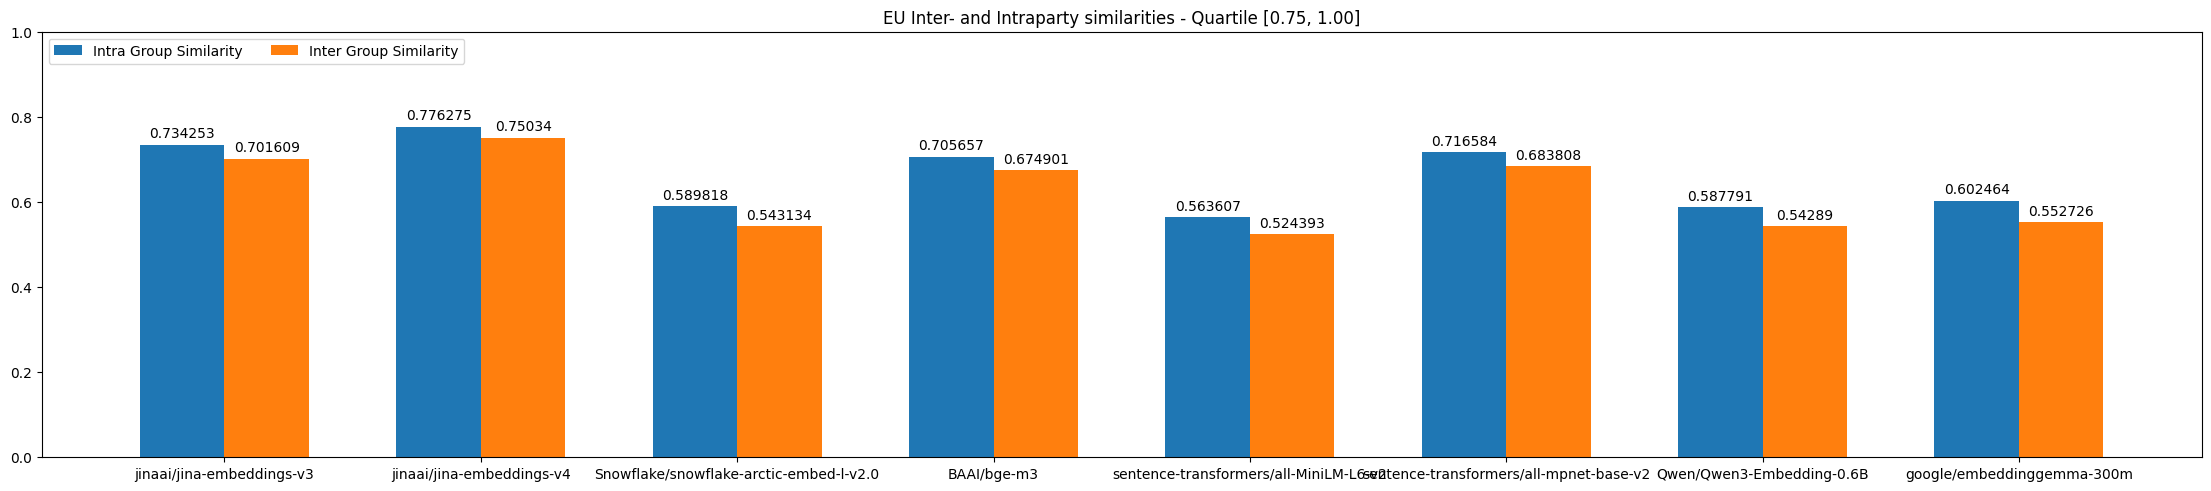

In [338]:
for quantile in range(0, 4):
    q_low = 0.25 * quantile
    q_high = 0.25 * (1 + quantile)
    length_low, length_high = df['text'].str.len().quantile(q=q_low), df['text'].str.len().quantile(q=q_high)
    similaritiy_metrics = []
    for model in models:
        similarities = get_intra_inter_similarities(df[(df['text'].str.len() >= length_low) & (df['text'].str.len() <= length_high)], 'eu_party', model)
        similaritiy_metrics.append({"Intra Group Similarity": similarities['intra'].mean(), "Inter Group Similarity": similarities['inter'].mean()})
    plot_similarities(similaritiy_metrics, f"EU Inter- and Intraparty similarities - Quartile [{q_low:.2f}, {q_high:.2f}]")

In [339]:
similaritiy_metrics = []
for model in models:
    similarities = get_intra_inter_similarities(df, 'agenda', model)
    similaritiy_metrics.append({"Intra Group Similarity": similarities['intra'].mean(), "Inter Group Similarity": similarities['inter'].mean()})

<Axes: title={'center': 'Agenda Inter- and Intrspeech similarities '}>

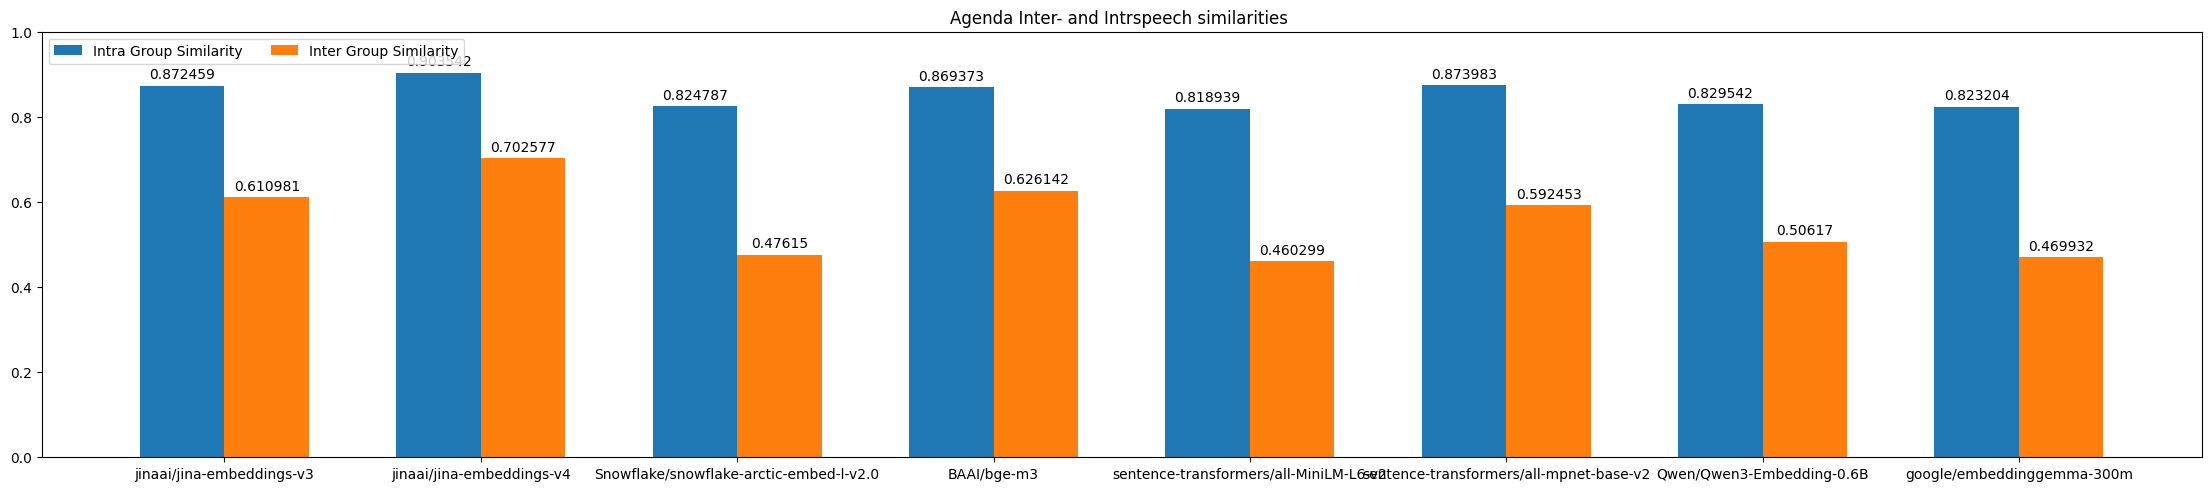

: 

In [ ]:
plot_similarities(similaritiy_metrics, f"Agenda Inter- and Intrspeech similarities ")